# Decoding strategies and parameters

We will be using `transformers` to generate next token sequences from a small model, and visualize the changes hyperparameters do to the probability distribution of the next token.


In [1]:
!pip install -q "transformers>=4.45.0" hf_transfer torch accelerate bitsandbytes plotly scipy tqdm matplotlib

import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Load the model and tokenizer

We will be using a non-instruct model for this excercise.

Non-instruct models, also known as causal language models, are designed for open-ended text generation tasks.

They predict the most likely next token based on the previous context, and do not follow specific commands like instruction-tuned models.

Careful prompting and tuning is required to produce usable outputs.


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# We will be using a non-instruct model for this excercise 
model_id = "Qwen/Qwen2.5-1.5B"
device = "cuda"

tokenizer = AutoTokenizer.from_pretrained(model_id, device_map=device)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map=device)


### Example of open-ended text generation

In [3]:
from transformers import TextStreamer

prompt = "2 + 2 = "

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

outputs = model.generate(inputs.input_ids, max_new_tokens=256, streamer=TextStreamer(tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


2 + 2 = 4 \) and \( 2^2 + 2^2 = 8 \), so \( 4 \) and \( 8 \) are not coprime.
- \( 2^3 + 2^3 = 16 \) and \( 2^2 + 2^2 = 8 \), so \( 16 \) and \( 8 \) are not coprime.
- \( 2^4 + 2^4 = 32 \) and \( 2^2 + 2^2 = 8 \), so \( 32 \) and \( 8 \) are not coprime.
- \( 2^5 + 2^5 = 64 \) and \( 2^2 + 2^2 = 8 \), so \( 64 \) and \( 8 \) are not coprime.
- \( 2^6 + 2^6 = 128 \) and \( 2^2 + 2^2 = 8 \), so \( 128 \) and \( 8 \) are not coprime.
- \( 2^7 + 2


## Logits and scores

Logits are the raw, unnormalized scores for each token in the vocabulary.

Scores are logits on top of which different transformations were applied depending on the decoding strategy.

Final probabilities are obtained by applying the `softmax` function to the scores.

### Retrieving logits and scores
Let's use the transformer's `generate` method to get a more detailed look at the output.

In [4]:
output_dict = model.generate(inputs.input_ids, max_new_tokens=1, output_scores=True, output_logits=True, return_dict_in_generate=True)

for key, value in output_dict.items():
    print(
        key, 
        value.shape if type(value) == torch.Tensor else f'Tuple of {value[0].shape}' if type(value[0]) == torch.Tensor else f'Tuple of tuple of {value[0][0].shape}'
    )

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


sequences torch.Size([1, 7])
scores Tuple of torch.Size([1, 151936])
logits Tuple of torch.Size([1, 151936])
past_key_values Tuple of tuple of torch.Size([1, 2, 6, 128])


`sequences` contains the generated sequence of tokens + last token.

In [5]:
output_dict['sequences']

tensor([[ 17, 488, 220,  17, 284, 220,  19]], device='cuda:0')

`logits` are the raw, unnormalized scores for each token in the vocabulary.  
Their shape is `(1, vocab_size)`

In [6]:
print(output_dict['logits'][0].shape)
output_dict['logits'][0][:,0:10]

torch.Size([1, 151936])


tensor([[ 4.0467, -1.9739,  2.8914,  5.2675,  0.1136,  1.6309, -0.9729,  3.1858,
          1.3045,  1.6879]], device='cuda:0')

`scores` are the logits on top of which different transformations were applied depending on the decoding strategy.  
Their shape is `(1, vocab_size)`

In [7]:
print(output_dict['scores'][0].shape)
output_dict['scores'][0][:,0:10]

torch.Size([1, 151936])


tensor([[ 4.0467, -1.9739,  2.8914,  5.2675,  0.1136,  1.6309, -0.9729,  3.1858,
          1.3045,  1.6879]], device='cuda:0')

Confirming the size of the vocabulary.

In [8]:
len(tokenizer.vocab)

151665

### Visualizing the top-k logit values and probabilities

Taking the top-k logit values, we can see the most likely next token in the first position.

In [9]:
output_dict['logits'][0].topk(5)

torch.return_types.topk(
values=tensor([[22.0941, 21.8434, 21.6329, 21.6252, 21.5669]], device='cuda:0'),
indices=tensor([[19, 16, 21, 15, 17]], device='cuda:0'))

Decoding the top-k indexes to tokens, we can understand how the the next token looks like.  
Observe that there are also strange results, such as `'Ġ', 'Ġ\\', 'âĳ',`. Those tokens contain linking characters that need to be decoded.

In [10]:
top_k = 15
# get top 15 results indexes
top_k_values = output_dict['logits'][0].topk(top_k).values
top_k_indexes = output_dict['logits'][0].topk(top_k).indices
# go from a tensor of shape (1, 15) to a tensor of shape (15, 1)
top_k_indexes = top_k_indexes.reshape(-1, 1)

tokenizer.convert_ids_to_tokens(top_k_indexes)


['4',
 '1',
 '6',
 '0',
 '2',
 '3',
 '8',
 '5',
 '7',
 '9',
 'Ġ',
 'Ġ\\',
 'âĳ',
 'Ġ-',
 'Ġ(']

We can convert each token to a string and visualize the true next token result.  

In [11]:
start_tokens = tokenizer.convert_ids_to_tokens(top_k_indexes)
for token in start_tokens:
    print(f'{token} => "{tokenizer.convert_tokens_to_string([token])}"')


4 => "4"
1 => "1"
6 => "6"
0 => "0"
2 => "2"
3 => "3"
8 => "8"
5 => "5"
7 => "7"
9 => "9"
Ġ => " "
Ġ\ => " \"
âĳ => "�"
Ġ- => " -"
Ġ( => " ("


The strange tokens were decoded to:
```
Ġ => " "
Ġ\ => " \"
âĳ => "�"
Ġ- => " -"
Ġ( => " ("
```

The character `Ġ` is used in BPE (Byte Pair Encoding) tokenizers to indicate a space, or the beginning of a new word.  
Example:  
```
["the", "Ġcat", "Ġsat"] => "the cat sat"
["cat", "like"] => "catlike"
```

But there is still `âĳ => "�"` that appears unreadable. Since the model can comunicate in non-latin languages, like chinese, it is likely that this token requires other additional tokens in its sequence to proberly decode into a valid unicode character. [[1]](https://en.wikipedia.org/wiki/Precomposed_character) [[2]](https://stackoverflow.com/a/70546429)  
Since we decoded each token separatly, the it failed for this usecase.

___

Now, let's visualize the top-k logit values.

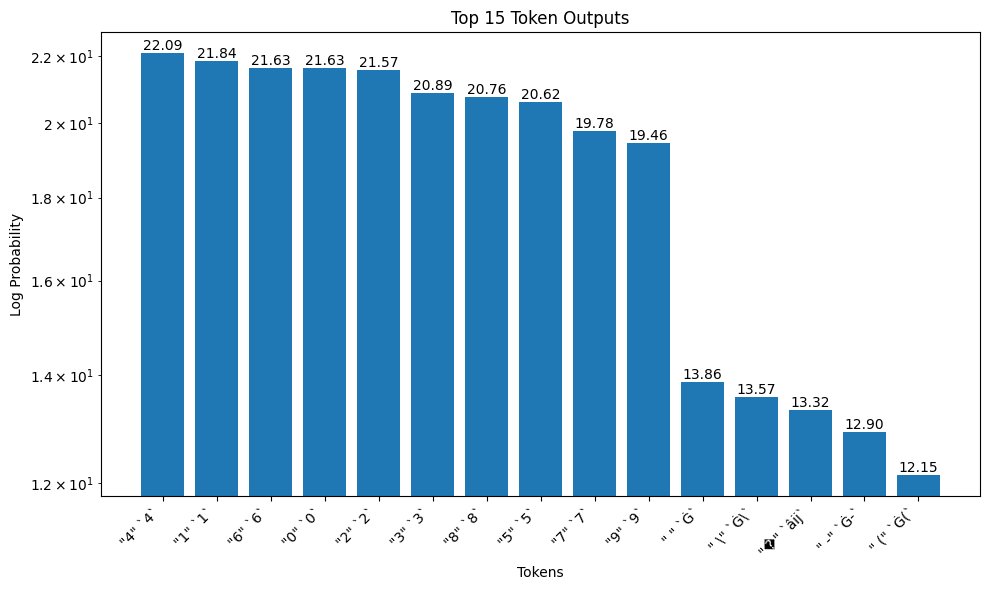

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Convert tensors to numpy arrays and move to CPU 
top_k_logits_values_np = top_k_values.cpu().numpy().flatten()
top_k_logits_indexes_np = top_k_indexes.cpu().numpy().flatten()

# Convert token indices to actual tokens
start_tokens = tokenizer.convert_ids_to_tokens(top_k_logits_indexes_np)
strings = [tokenizer.convert_tokens_to_string([token]) for token in start_tokens]

# Create labels for x-axis
labels = [f'"{string}" `{token}`' for token, string in zip(start_tokens, strings)]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, np.round(top_k_logits_values_np, 2))

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Customize the plot
plt.title(f'Top {len(top_k_logits_values_np)} Token Outputs')
plt.xlabel('Tokens')
plt.ylabel('Log Probability')
plt.yscale('log')
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


And top-k score probabilities.

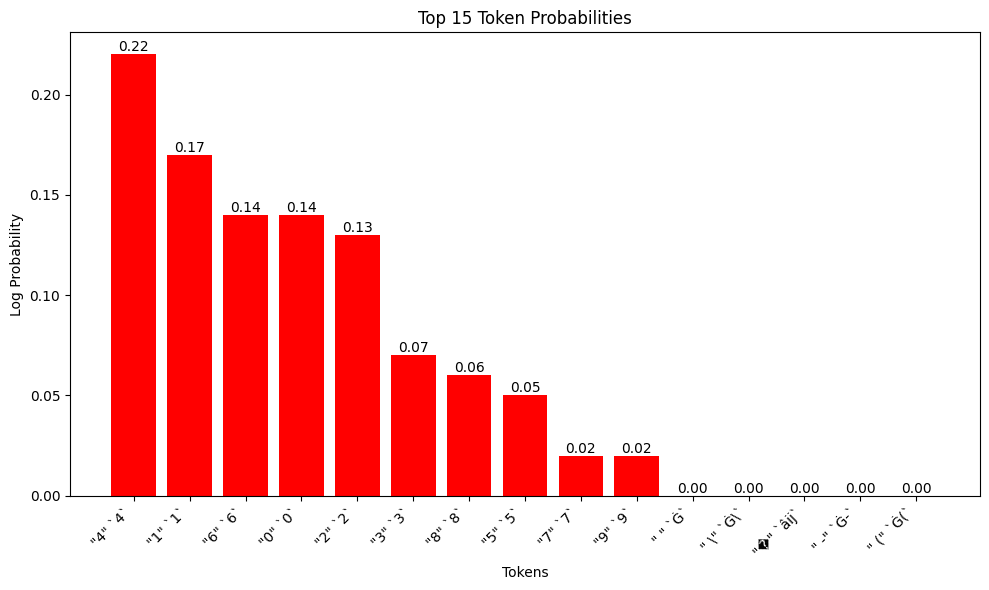

In [13]:
from scipy.special import softmax
import matplotlib.pyplot as plt

# Create labels for x-axis
labels = [f'"{string}" `{token}`' for token, string in zip(start_tokens, strings)]
probabilities = np.round(softmax(top_k_logits_values_np), 2)

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, probabilities, color='red')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Customize the plot
plt.title(f'Top {len(probabilities)} Token Probabilities')
plt.xlabel('Tokens')
plt.ylabel('Log Probability')
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

We'll create a helper function to visualize the top-k logit values and probabilities for later use

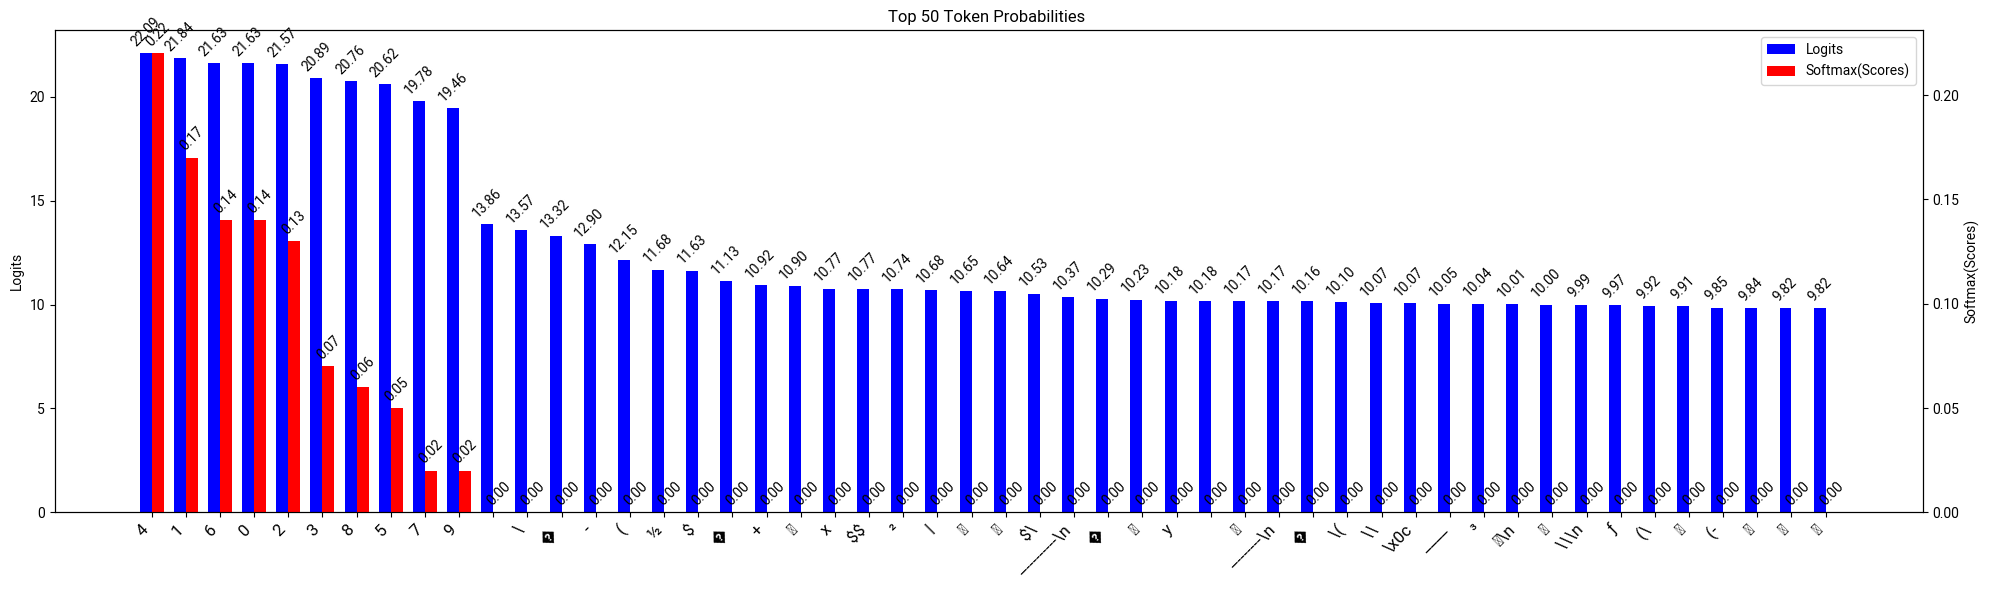

In [14]:
from scipy.special import softmax
from matplotlib.font_manager import fontManager
from IPython.utils.capture import capture_output

# filter out warnings
import warnings
warnings.filterwarnings('ignore', 
                       category=UserWarning,
                       module='IPython.core.pylabtools')

fontManager.addfont('./.images/Roboto-Regular.ttf')

def visualize_top_k_tokens(logits, scores = [], k=5, name: str = '', figsize=(20, 6), show=True, return_fig=False):
    tok_k = logits.topk(k)
    top_k_values = tok_k.values
    top_k_indexes = tok_k.indices

    # Convert tensors to numpy arrays and move to CPU 
    top_k_logits_values_np = top_k_values.cpu().numpy().flatten()
    top_k_logits_indexes_np = top_k_indexes.cpu().numpy().flatten()

    if torch.is_tensor(scores):
        scores = scores.cpu().numpy().flatten()
    top_k_scores_values_np = softmax(scores)[top_k_logits_indexes_np]

    # Convert token indices to actual tokens
    tokens = tokenizer.convert_ids_to_tokens(top_k_logits_indexes_np)

    strings = []
    for token in tokens:
        # Convert to string
        s = tokenizer.convert_tokens_to_string([token])
        # Escape special characters and replace problematic ones
        s = (s
            #  .replace(' ', '_') # Replace spaces with underscores to be more visible
             .replace('$', r'\$')  # Escape dollar signs
             .replace('\n', r'\n')  # Show newlines as \n
             .replace('\x0c', r'\x0c')  # Show form feed as \x0c
             )
        strings.append(s)

    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=figsize)
    ax2 = ax1.twinx()

    # Plot logits on left y-axis
    x = np.arange(len(strings))
    width = 0.35
    rects1 = ax1.bar(x - width/2, np.round(top_k_logits_values_np, 2), width, 
                     label='Logits', color='blue')
    ax1.set_ylabel('Logits')

    # Plot scores on right y-axis  
    rects2 = ax2.bar(x + width/2, np.round(top_k_scores_values_np, 2), width,
                     label='Softmax(Scores)', color='red')
    ax2.set_ylabel('Softmax(Scores)')

    # Add value labels on top of bars
    def autolabel(rects, ax):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=45)

    autolabel(rects1, ax1)
    autolabel(rects2, ax2)

    # Customize the plot
    plt.title(f'Top {k} Token Probabilities {name}')
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Roboto']
    ax1.set_xticks(x)
    ax1.set_xticklabels(strings, rotation=45, ha='right', fontsize=12)
    
    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    # suppress warnings
    with capture_output():
        plt.tight_layout()

    if show:
        plt.show()

    if return_fig:
        return fig
    else:
        return None

visualize_top_k_tokens(output_dict['logits'][0], output_dict['scores'][0], 50)

Let's also create a helper function to generate logits and scores for ease of use.

In [15]:
def generate_logits(prompt, **extra_generation_config):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    output_dict = model.generate(
        **inputs,
        max_new_tokens=1,
        output_scores=True,
        output_logits=True,
        return_dict_in_generate=True,
        pad_token_id=tokenizer.eos_token_id,
        **extra_generation_config,
    )

    return {"logits": output_dict["logits"][0], "scores": output_dict["scores"][0]}

And let's test them both!

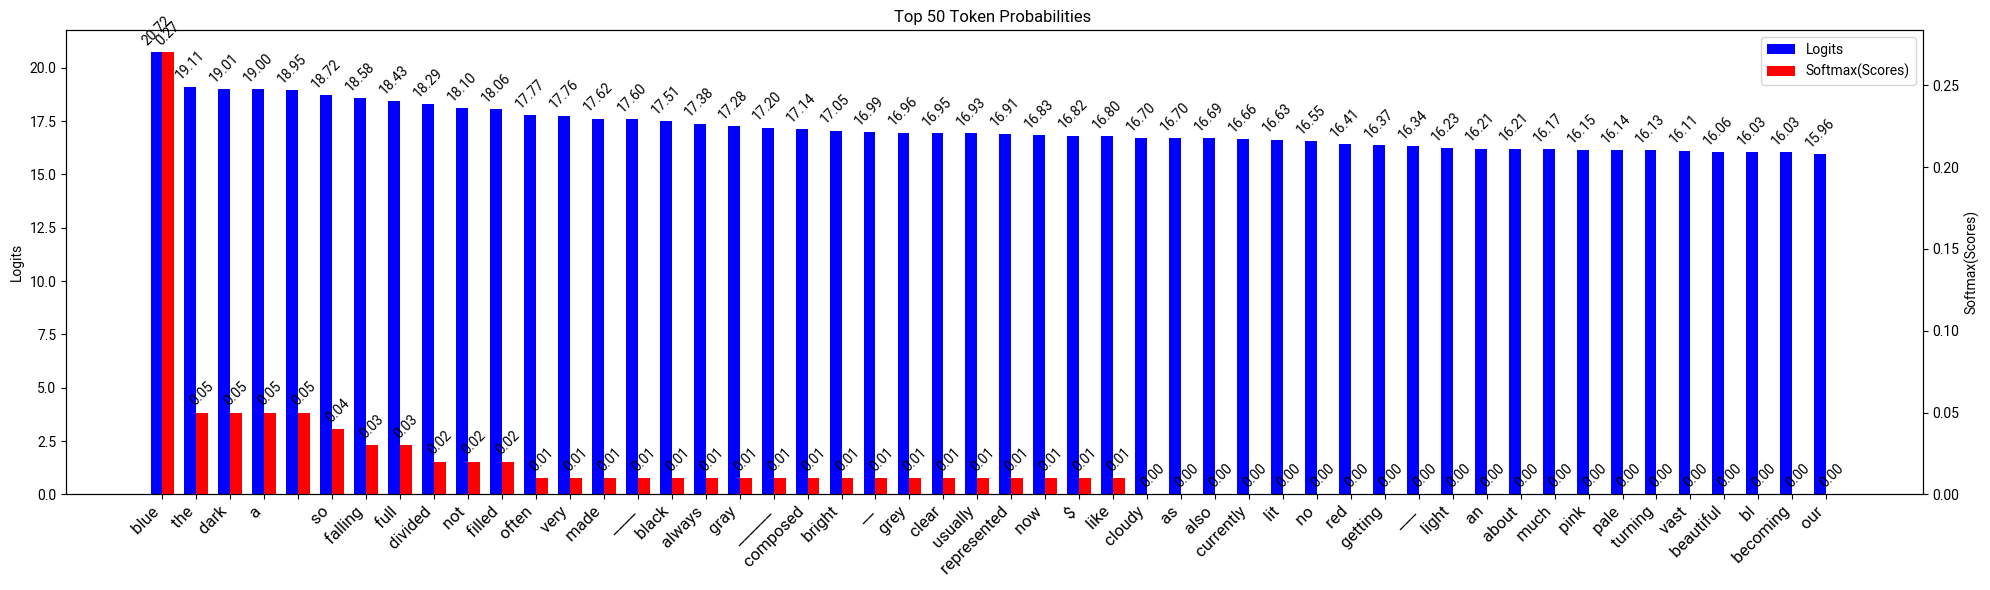

In [16]:
logits = generate_logits("The sky is")
visualize_top_k_tokens(logits['logits'], logits['scores'], 50)

## Greedy search decoding strategy

Greedy search is the simplest decoding method. It selects the word with the highest probability as its next word.

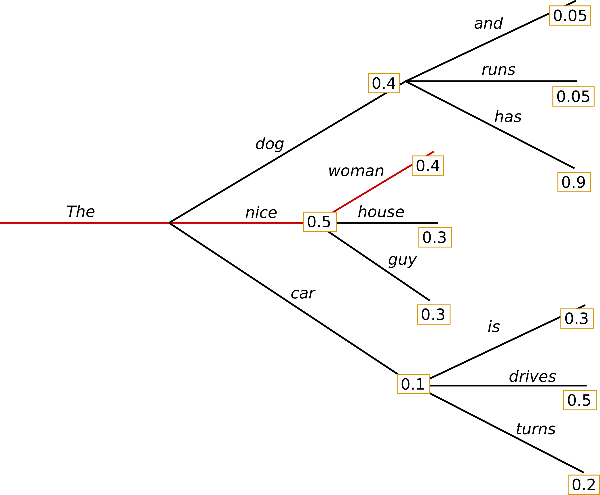


In the image above, starting from the word "The", the algorithm greedily chooses the next word of highest probability "nice" and so on, so that the final generated word sequence is `("The", "nice", "woman")` having an overall probability of `0.5×0.4=0.2`.

Here, we start with "My name is" and greedily select the next token of highest probability.

My name is John


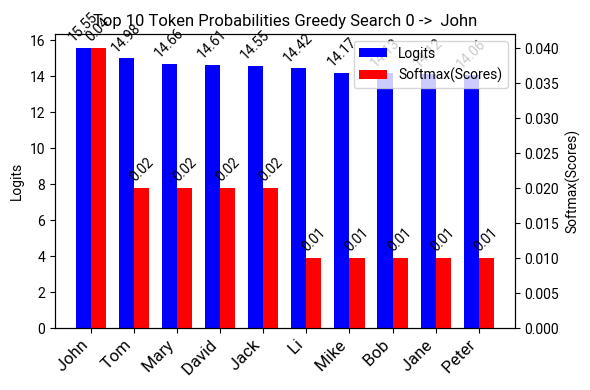

My name is John.


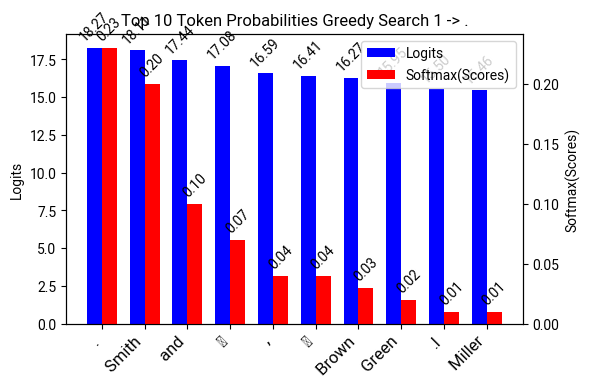

My name is John. I


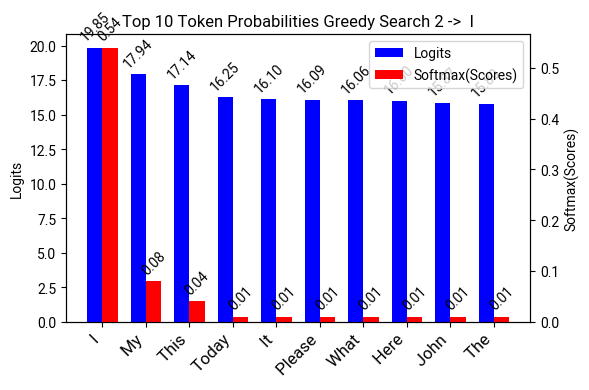

My name is John. I am


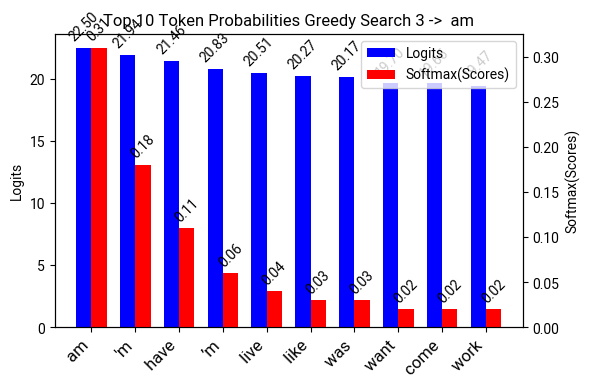

My name is John. I am a


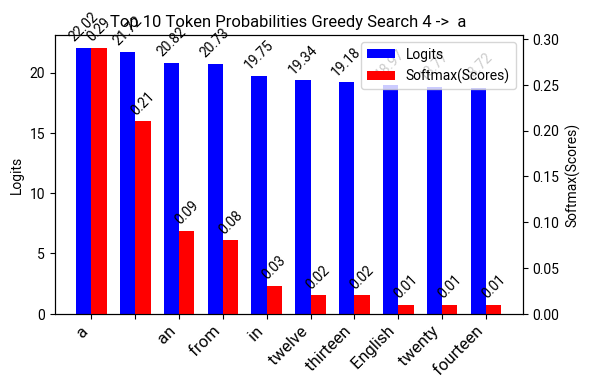

In [17]:
prompt = "My name is"

for _ in range(5):
    logits = generate_logits(prompt)

    top_1 = logits['scores'][0].topk(1).indices
    string = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(top_1))

    prompt += string
    print(prompt)
    visualize_top_k_tokens(logits['logits'], logits['scores'], 10, name=f'Greedy Search {_} -> {string}', figsize=(6, 4))


And here is how it looks like after decoding 32 iterations.

In [18]:
prompt = "My name is"

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

outputs = model.generate(**inputs, pad_token_id=tokenizer.eos_token_id, max_new_tokens=32, streamer=TextStreamer(tokenizer))

My name is John. I am a student. I am in Class 3, Grade 7. I have a good friend. His name is Mike. He is a


## Sample decoding strategies

Those strategies are applied over the `logits` to compute `scores`.   
They are simple because they only need the current state of the `logits` to compute the `scores`

Activated in the transformers library by setting the `do_sample` parameter.

Sampling takes all the `scores` and transforms them into probabilities using the `softmax` function.  
The the probabilities are then used to randomly pick the next token, weighted by their softmax value.


Here, we have the top 10 probabilities of the next token for the prompt `2 + 2 = `:   
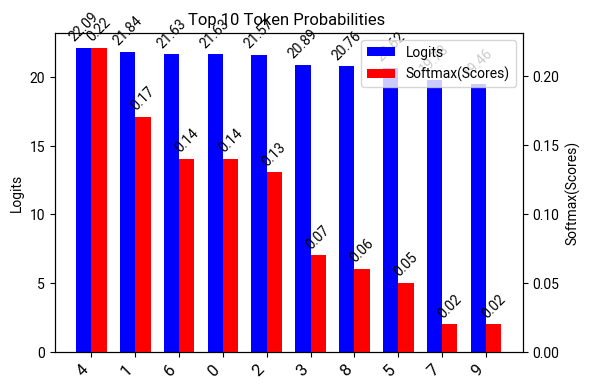

Visualizing the top 10 probabilities as a pie chart, we get the following:  
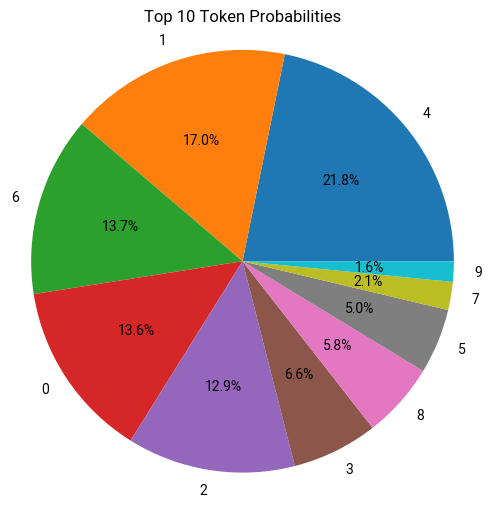

If we were to spin it as a wheel, the change of it stopping at:
- 4 is 21.79%
- 1 is 16.95%
- 6 is 13.74%
- 0 is 13.63%
- 2 is 12.86%
- 3 is 6.56%
- 8 is 5.76%
- 5 is 4.98%
- 7 is 2.15%
- 9 is 1.56%


### Temperature

The temperature parameter is used to modulate the next token probabilities.

`scores = logits / temperature`

It normally ranges between 0 and 1, some APIs (like Gemini) may allow you to go above 1, but they are most likely using a different formula.

Setting temperature to 0.0 has the same effect as greedy search, since only the highest probability token will have a non-zero score.

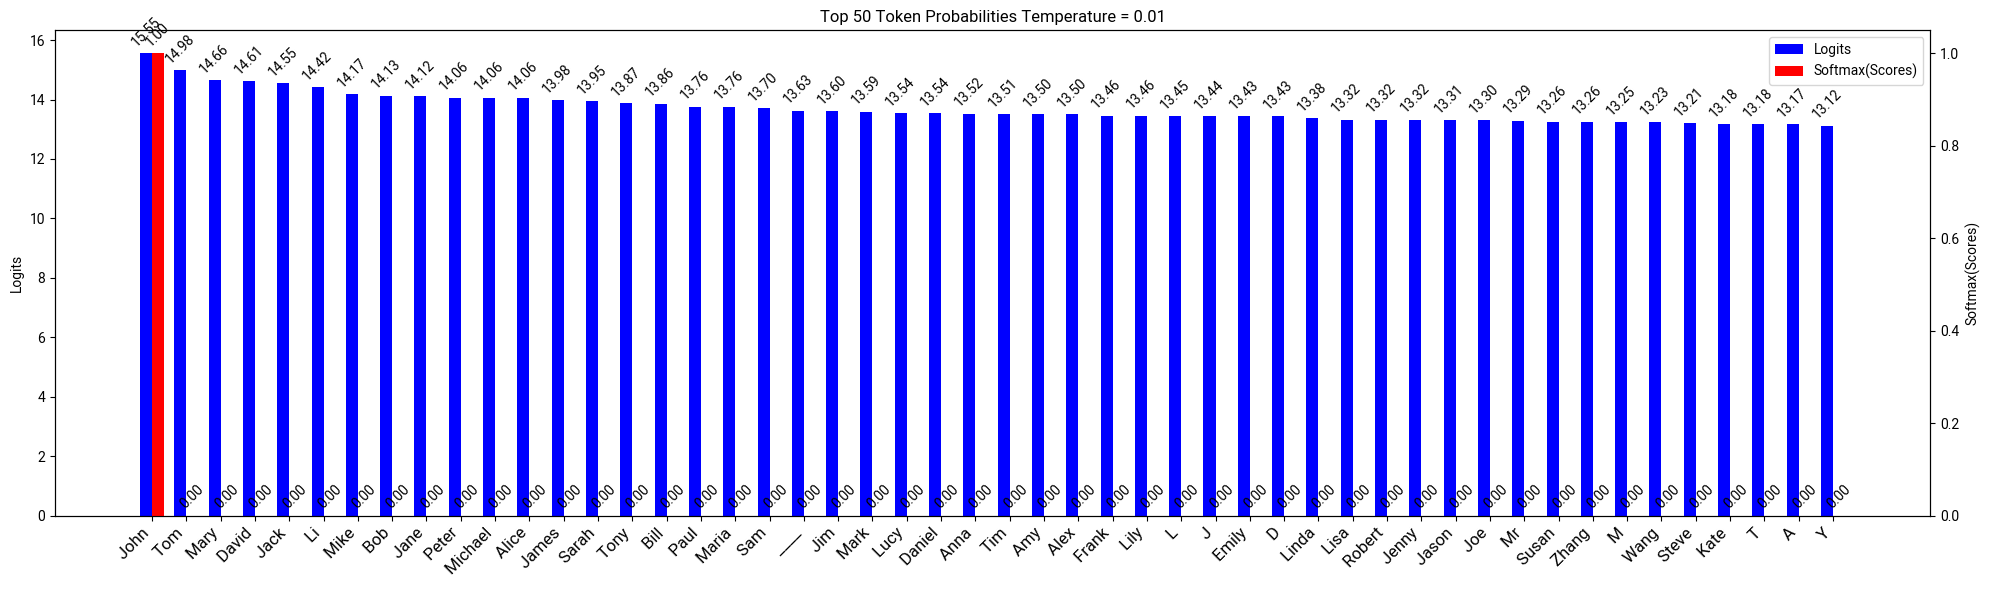

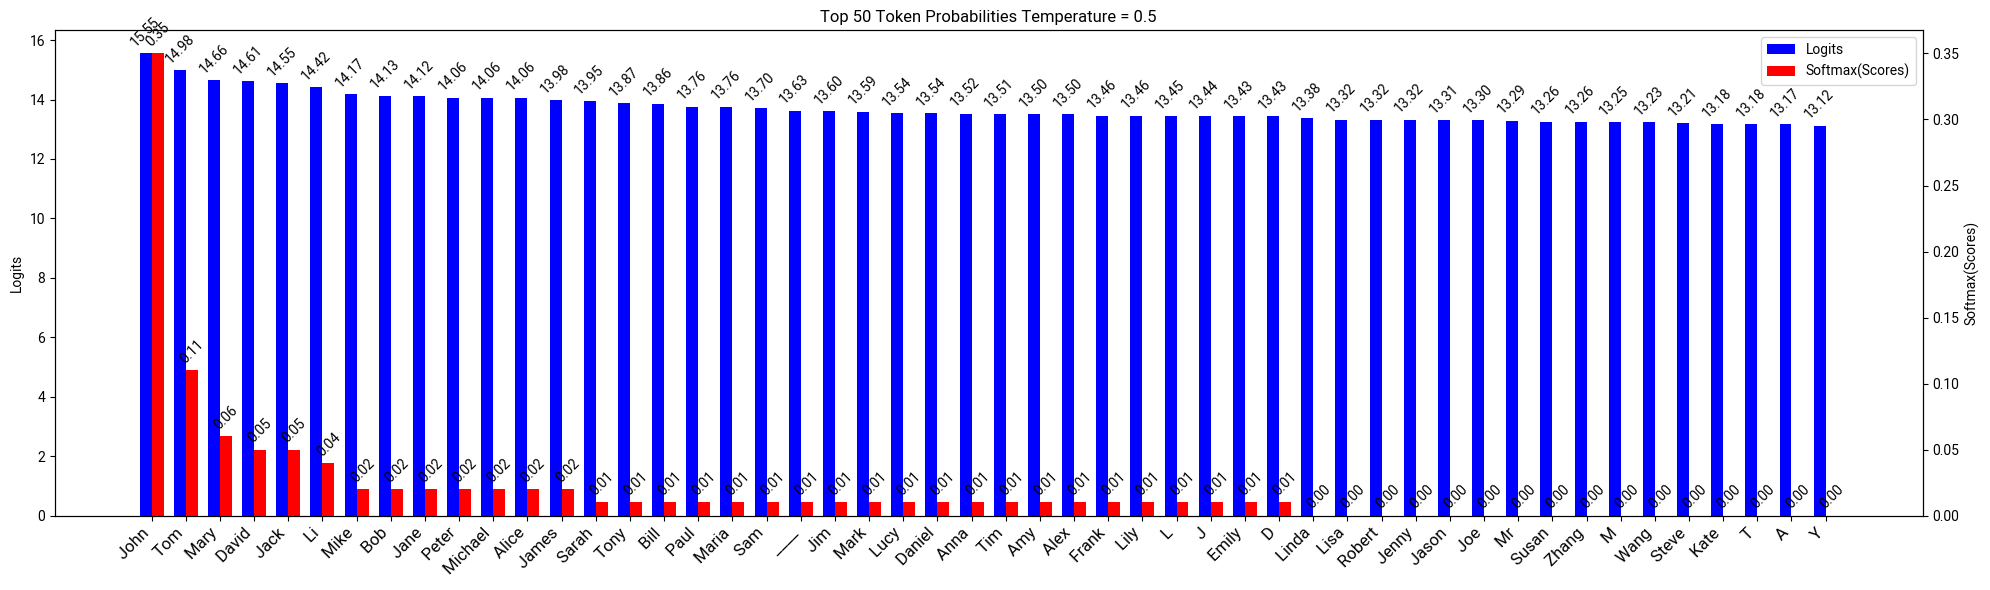

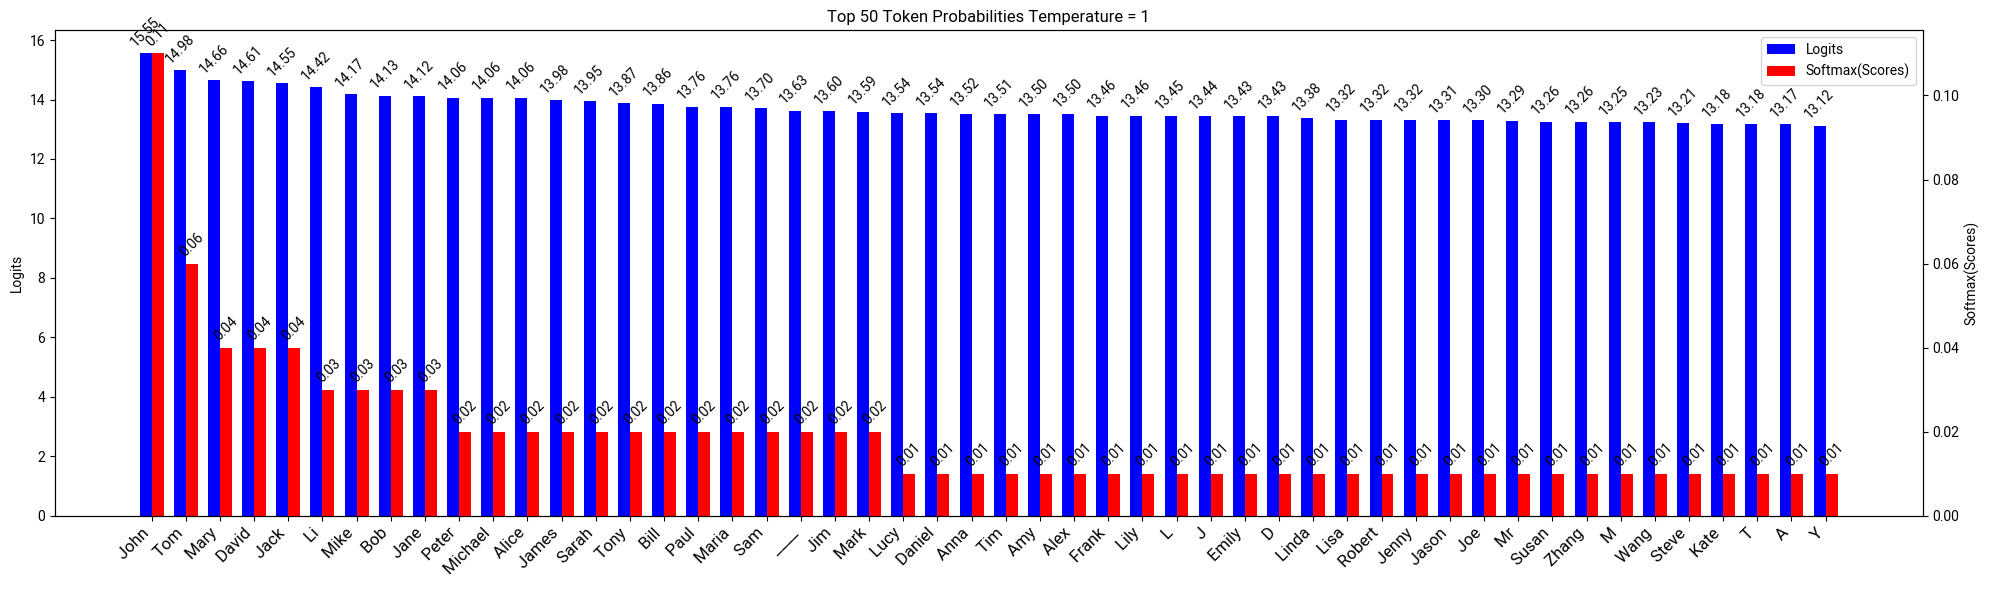

In [19]:
# prompt = '2 + 2 = '
prompt = 'My name is'

logits = generate_logits(prompt, do_sample=True, temperature=0.01)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Temperature = 0.01')

logits = generate_logits(prompt, do_sample=True, temperature=0.5)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Temperature = 0.5')

logits = generate_logits(prompt, do_sample=True, temperature=1)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Temperature = 1')

We will continue with a temperature of 1 to exagerate the results and more easily showcase the effects of other parameters.


### Top-k

The top-k parameter is used to limit the next token choices to the top-k most likely tokens.

Setting `top_k` to 1 is equivalent to greedy search as only the highest probability token will be selected.

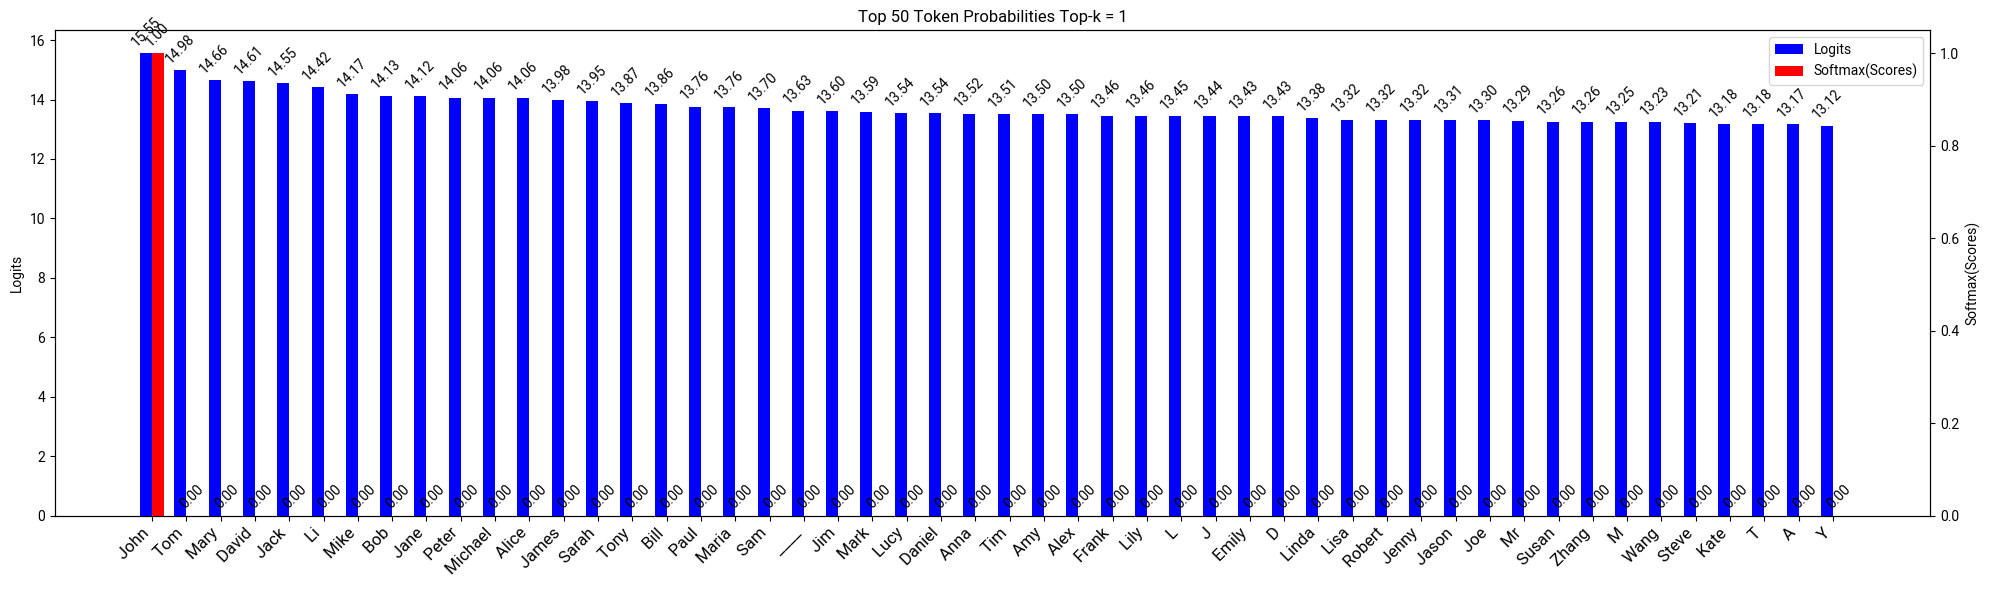

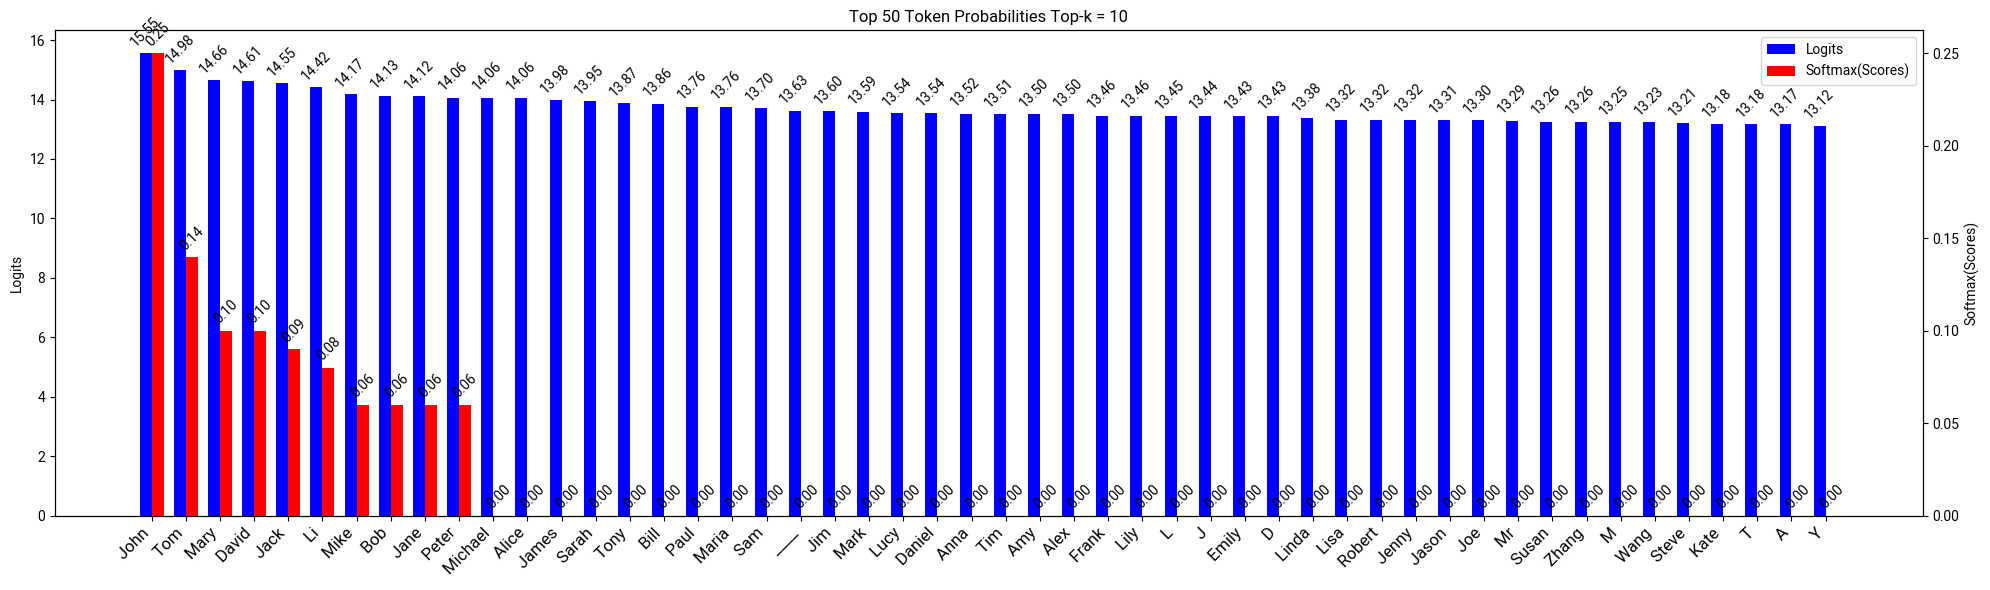

In [20]:
prompt = "My name is"

logits = generate_logits(prompt, do_sample=True, temperature=1, top_k=1)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Top-k = 1')

logits = generate_logits(prompt, do_sample=True, temperature=1, top_k=10)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Top-k = 10')

### Top-p

The top-p parameter is used to limit the next token choices to the smallest set of most probable tokens with probabilities that add up to `top_p` or higher.

Setting `top_p` to a higher value will take into account more tokens, a lower value will narrow the set of tokens to only the most likely ones. 

A value of 0 or close to 0 is equivalent to greedy search as only the highest probability token will have a non-zero softmax score.

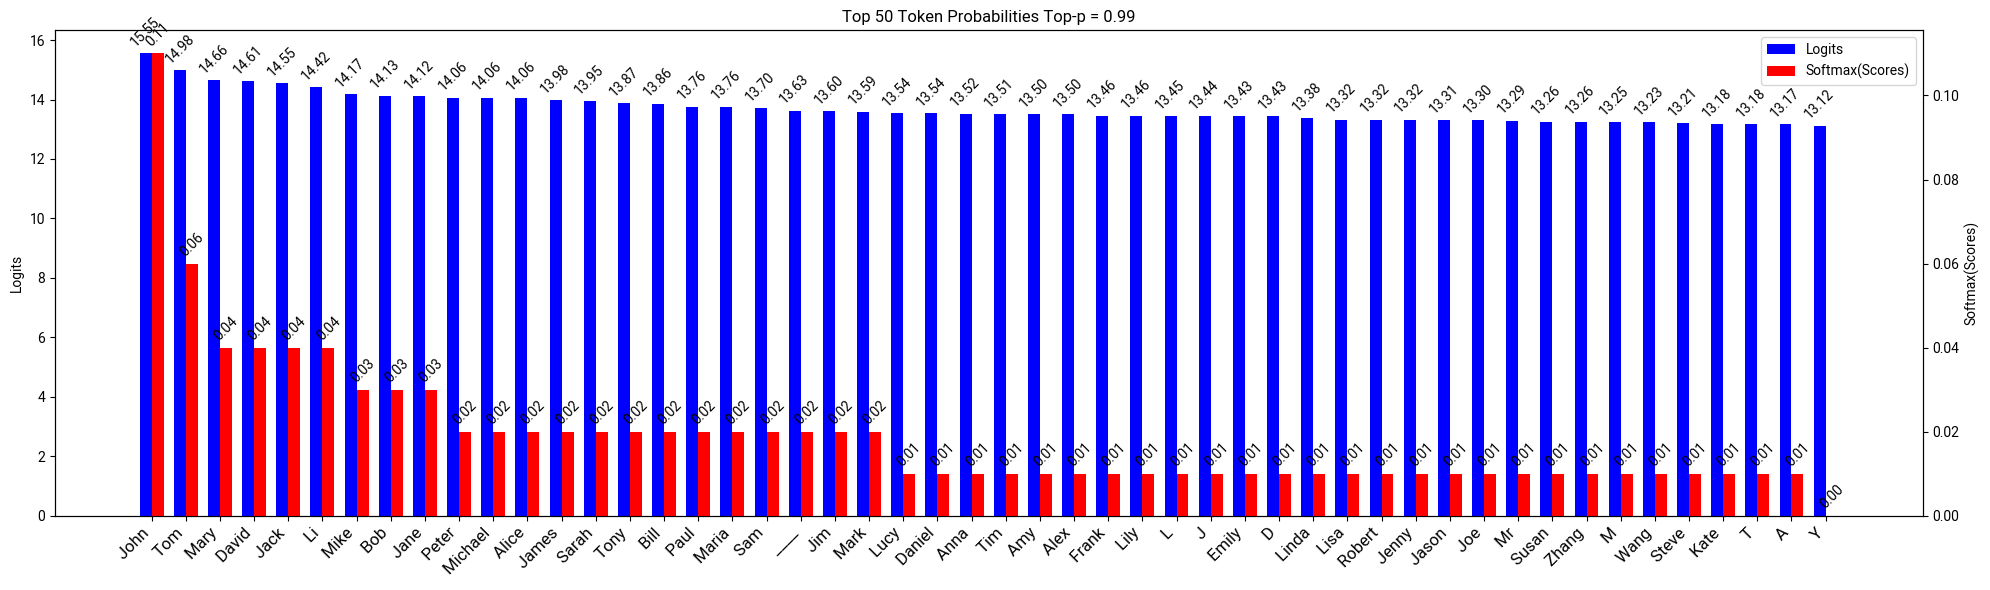

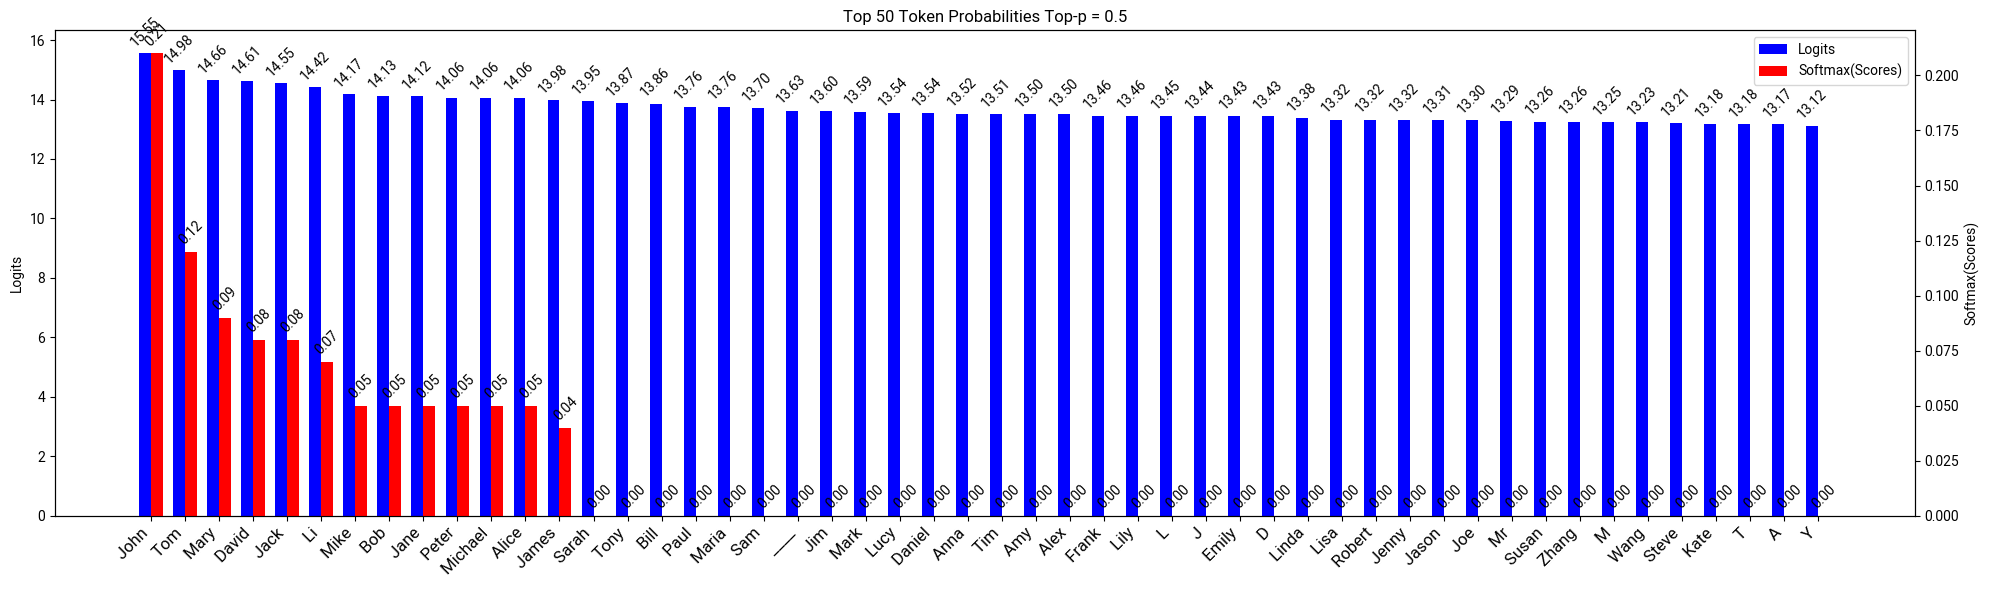

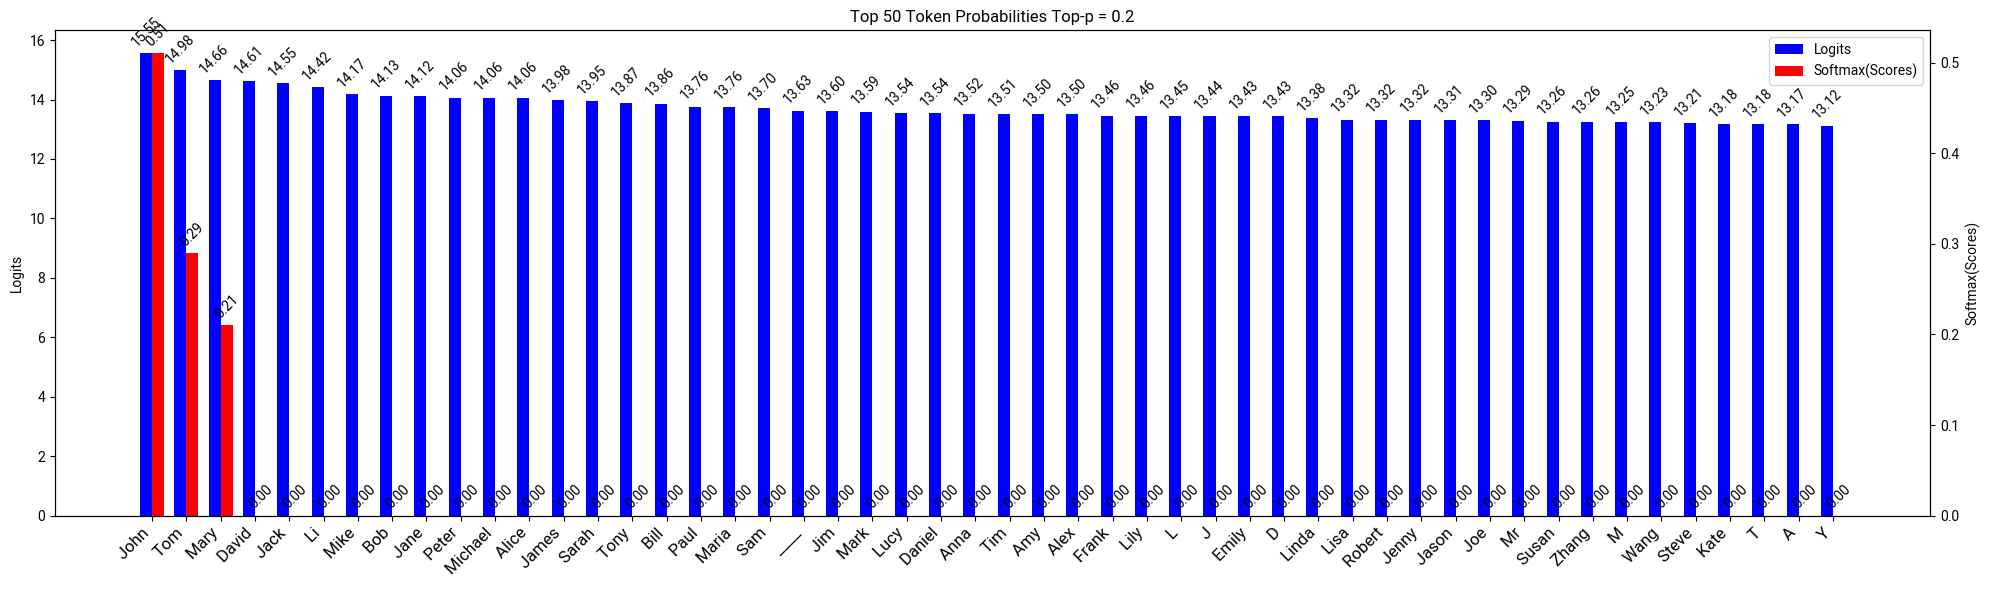

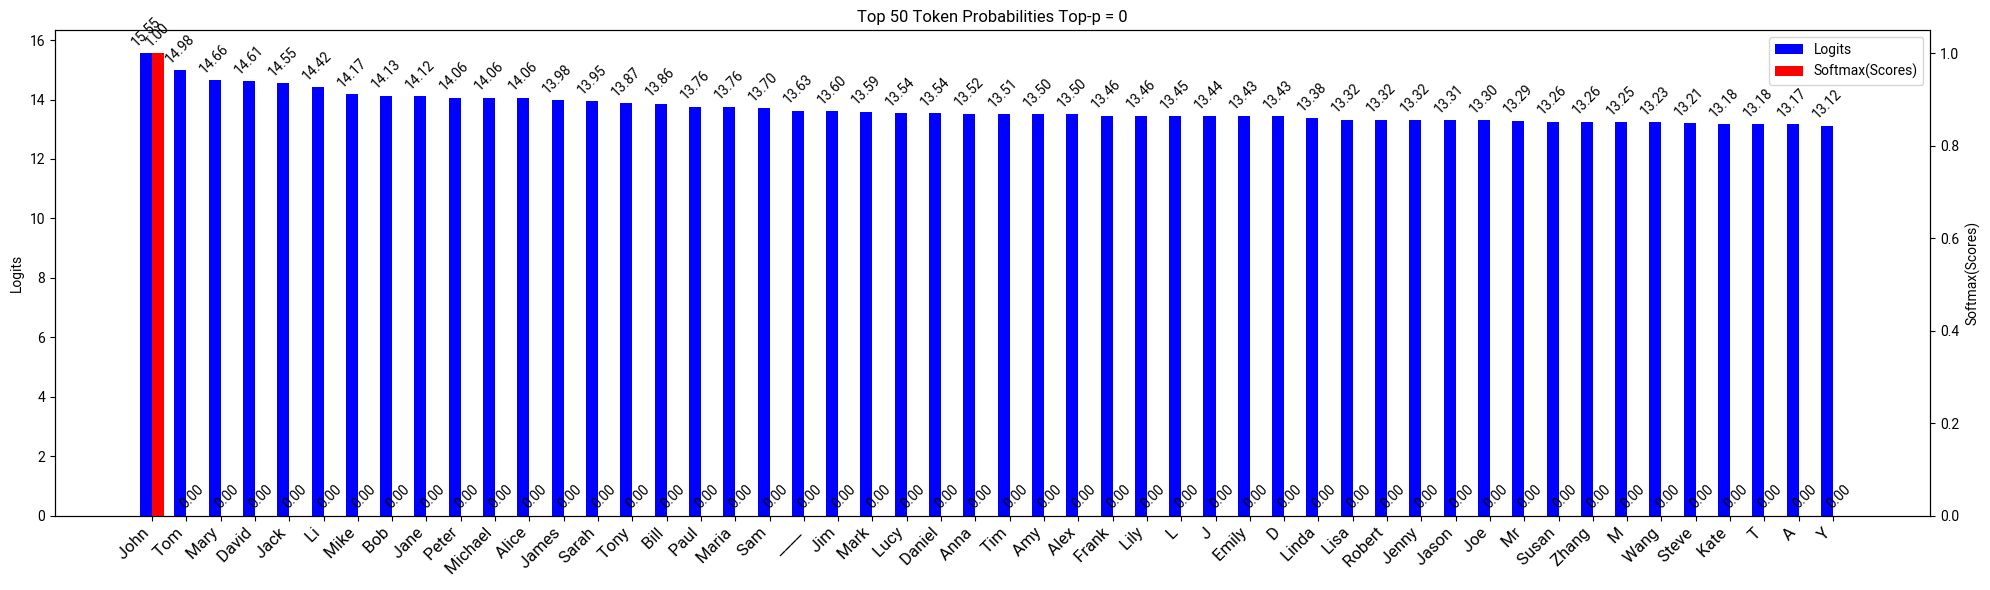

In [21]:
prompt = "My name is"

logits = generate_logits(prompt, do_sample=True, temperature=1, top_p=0.99)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Top-p = 0.99')

logits = generate_logits("My name is", do_sample=True, temperature=1, top_p=0.5)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Top-p = 0.5')

logits = generate_logits("My name is", do_sample=True, temperature=1, top_p=0.2)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Top-p = 0.2')

logits = generate_logits("My name is", do_sample=True, temperature=1, top_p=0)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Top-p = 0')

### Min-P

Minimum token probability, which will be scaled by the probability of the most likely token. It must be a value between 0 and 1.  
Typical values are in the 0.01-0.2 range. This has the opposite effect of `top_p`.

Values close to 0 will take take into account more tokens, while values close to 1 will take into account less tokens.

A value of 1 or close to 1 is equivalent to greedy search as only the highest probability token will have a non-zero softmax score.

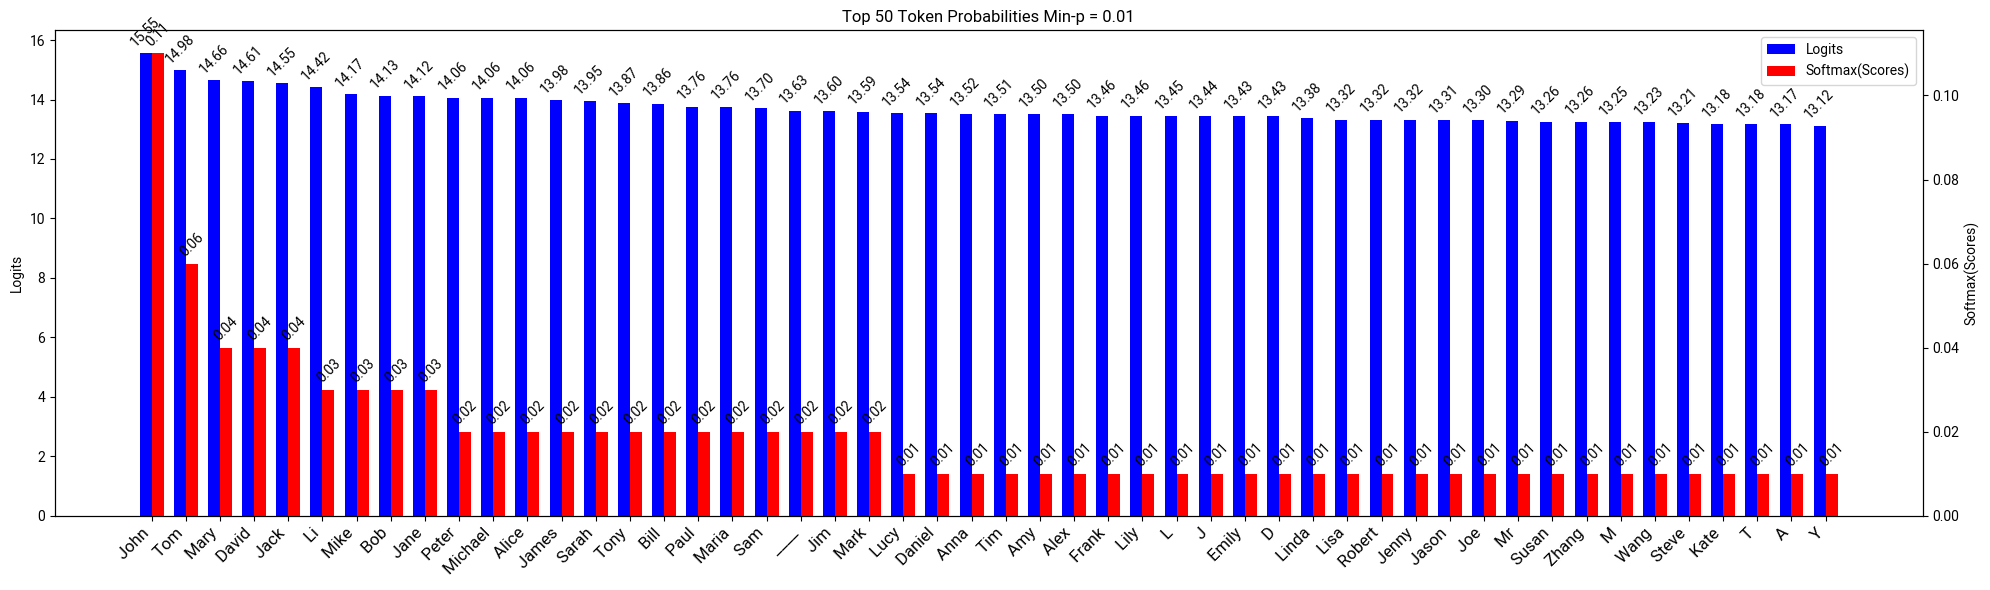

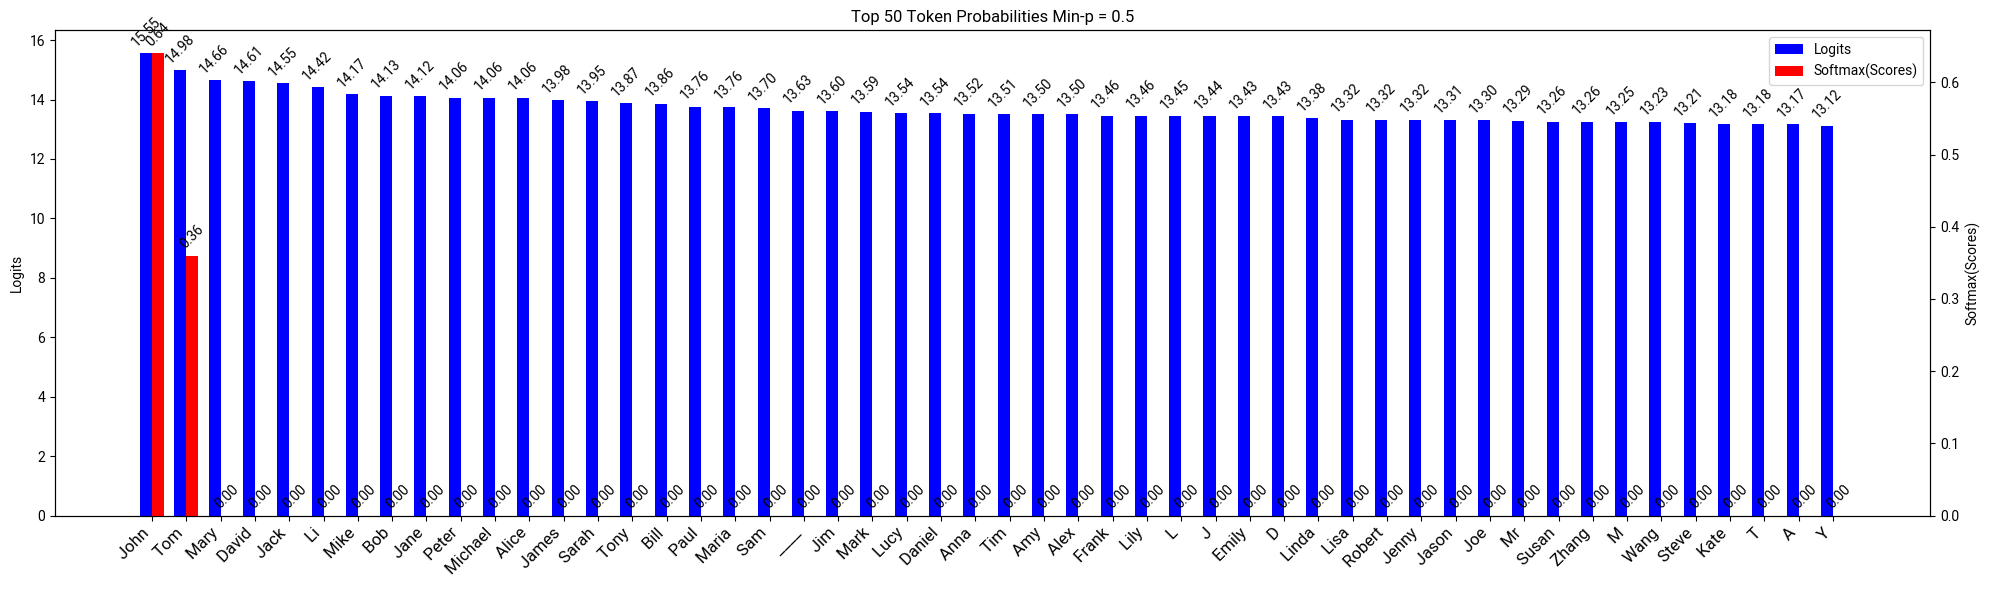

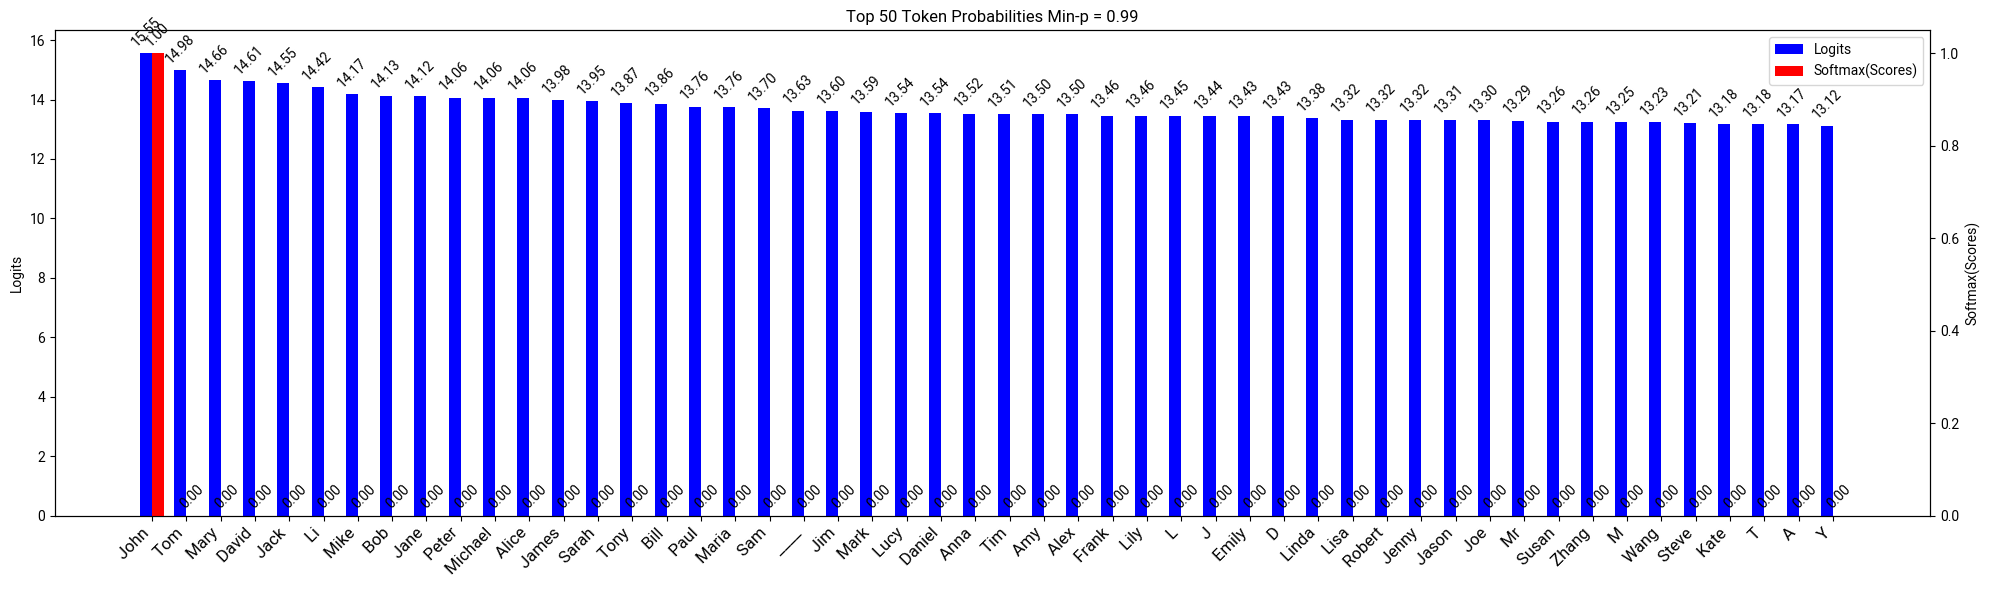

In [22]:
prompt = "My name is"

logits = generate_logits(prompt, do_sample=True, temperature=1, min_p=0.01)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Min-p = 0.01')

logits = generate_logits(prompt, do_sample=True, temperature=1, min_p=0.5)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Min-p = 0.5')

logits = generate_logits(prompt, do_sample=True, temperature=1, min_p=0.99)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Min-p = 0.99')


### Typical P

Typical P helps select tokens that are "normally expected" in a given context, rather than just picking the most likely ones.  

Here's how it works:  
1. For each possible next token, it measures how "typical" or "normal" that token would be in the current context  
2. A token is considered more "typical" if its probability is close to what we'd expect for an average token in that position  
3. When typical_p is set (e.g. `typical_p=0.9`), it keeps only the most typical tokens whose probabilities sum up to that value  

---

Example:  
If you're writing a sentence about food and see the word "eat", the next word could be:   
- Very likely but unusual: "food" (high probability but not typical)  
- Less likely but more typical: "dinner" (moderate probability but very typical)  

Typical P would prefer "dinner" because it's more natural in everyday language   

---

This helps the model generate text that sounds more natural and avoids unusual word choices, even if those unusual words have high raw probabilities.  
Setting a lower `typical_p` value (like `0.2`) makes the text more focused and conventional, while higher values (like `0.9`) allow for more creative but still natural-sounding variations

See [this paper](https://arxiv.org/pdf/2202.00666.pdf) for more details.

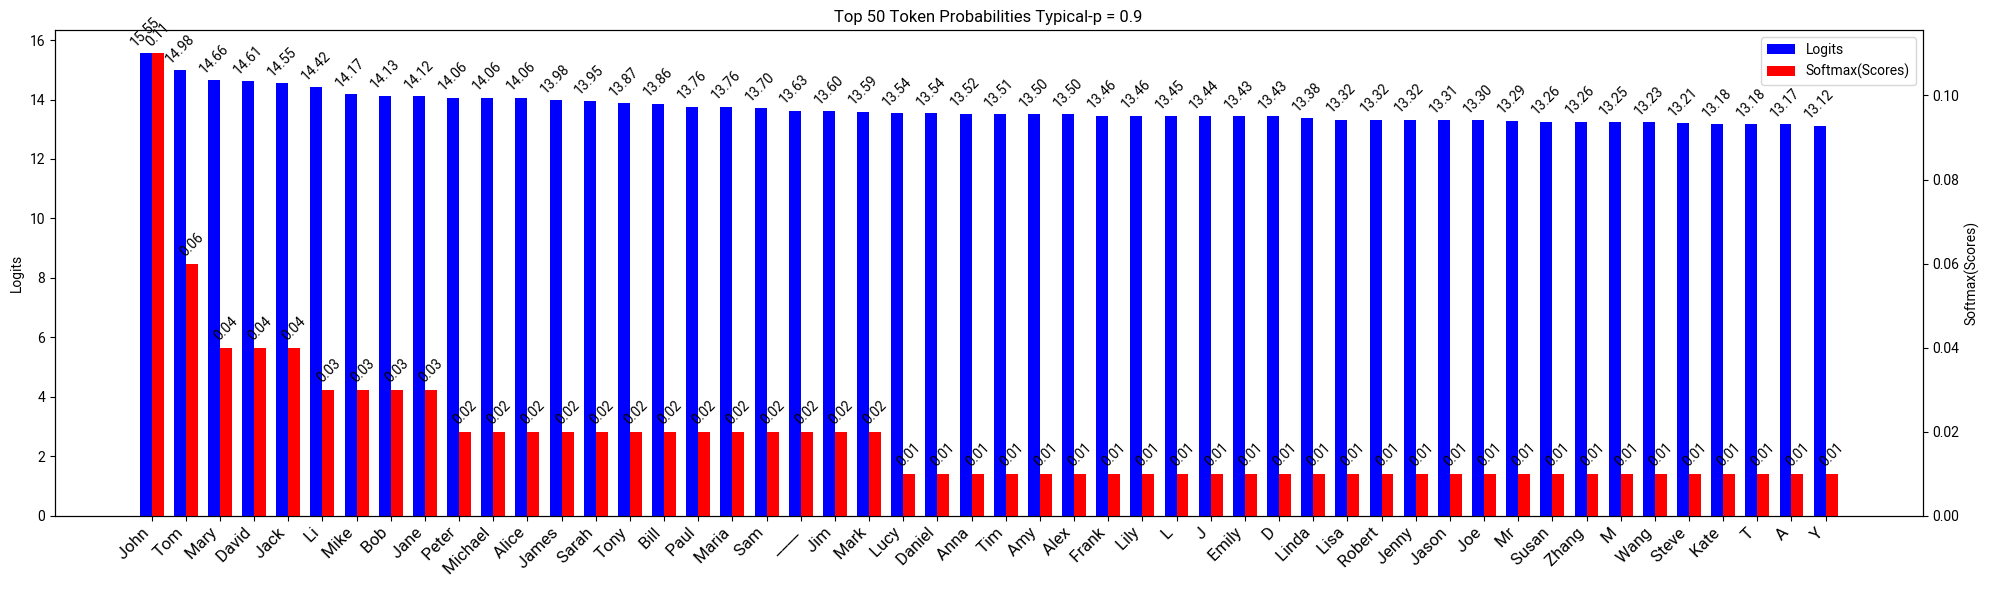

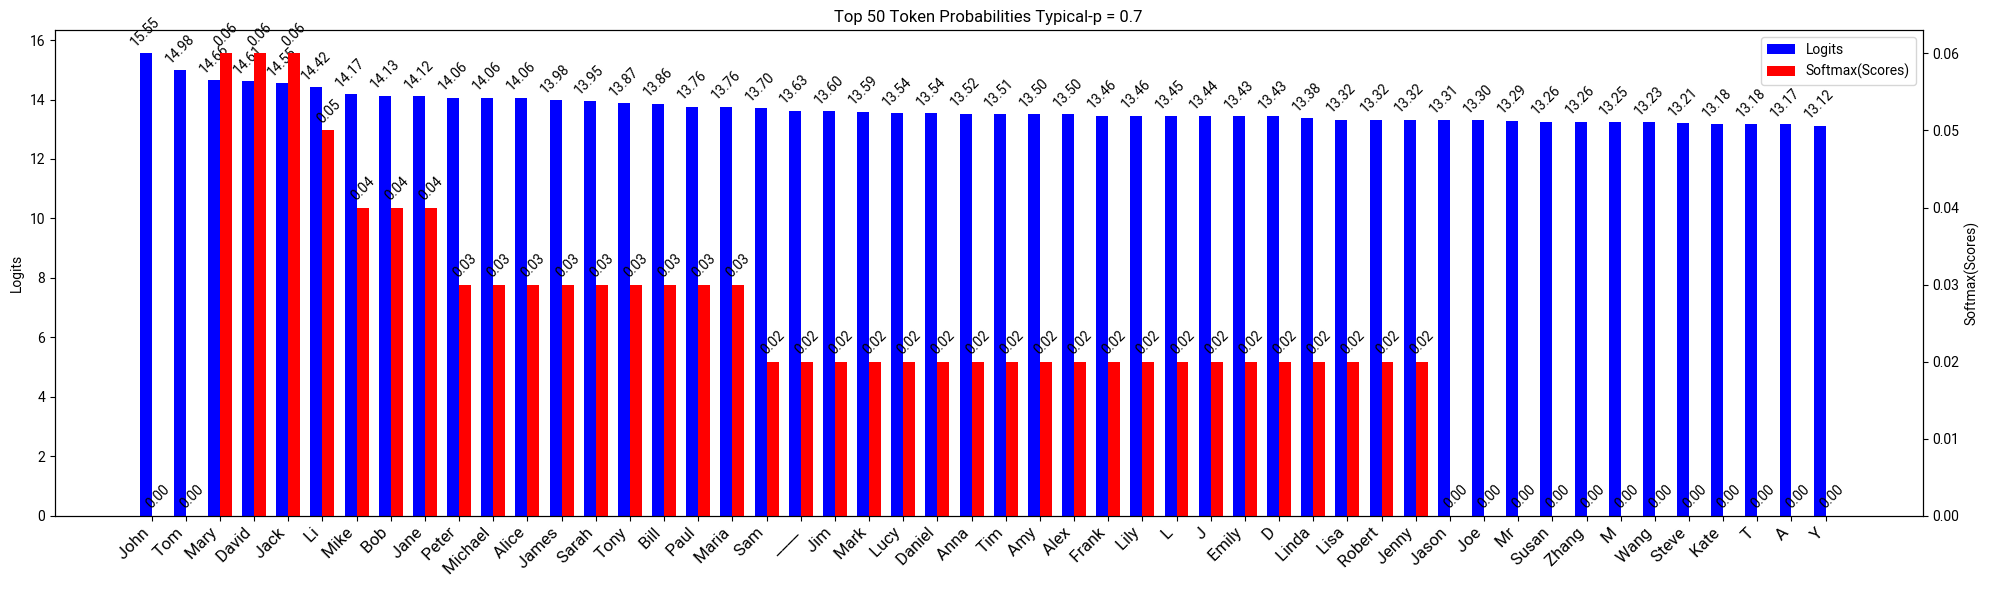

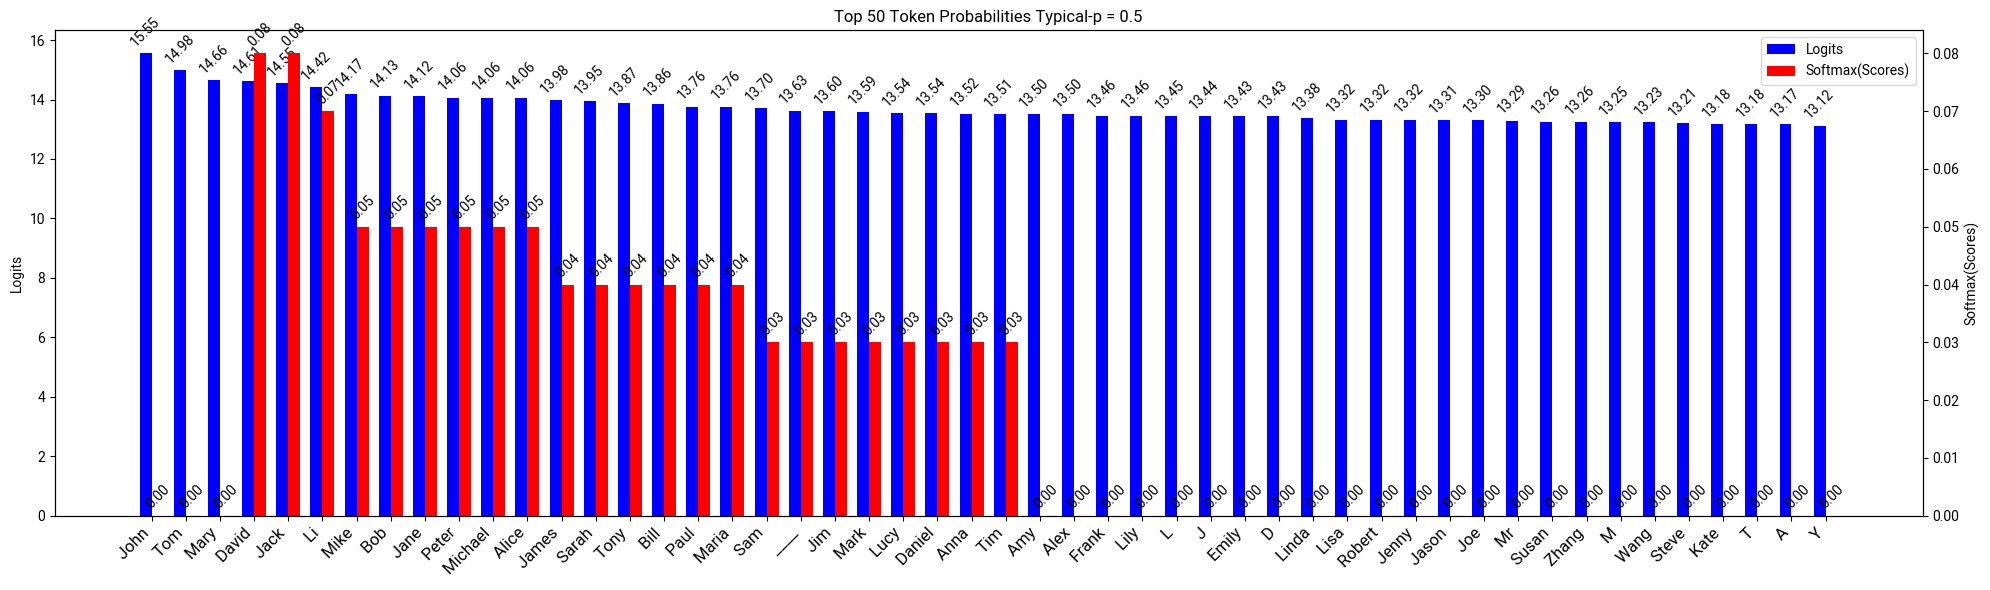

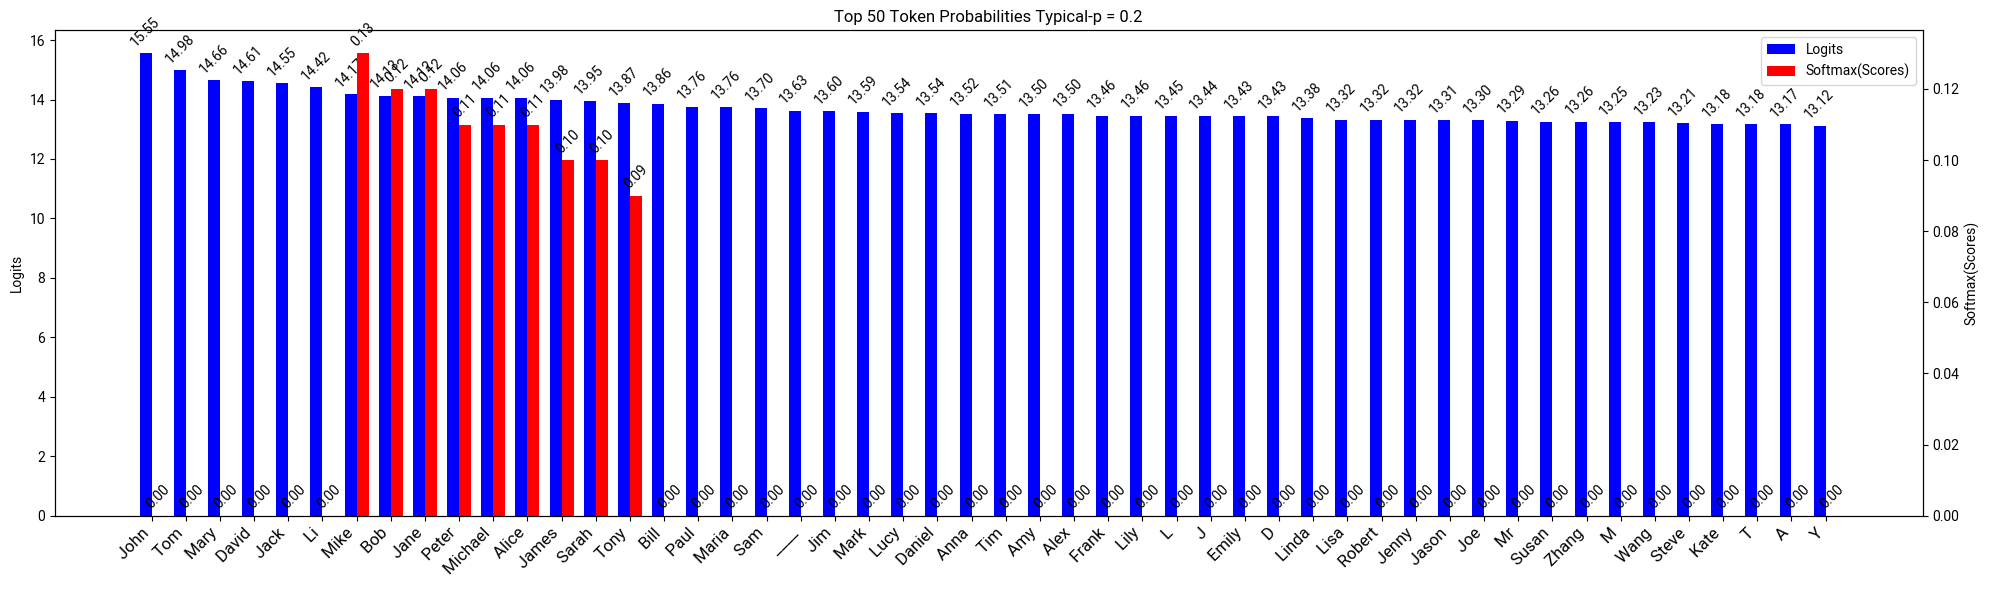

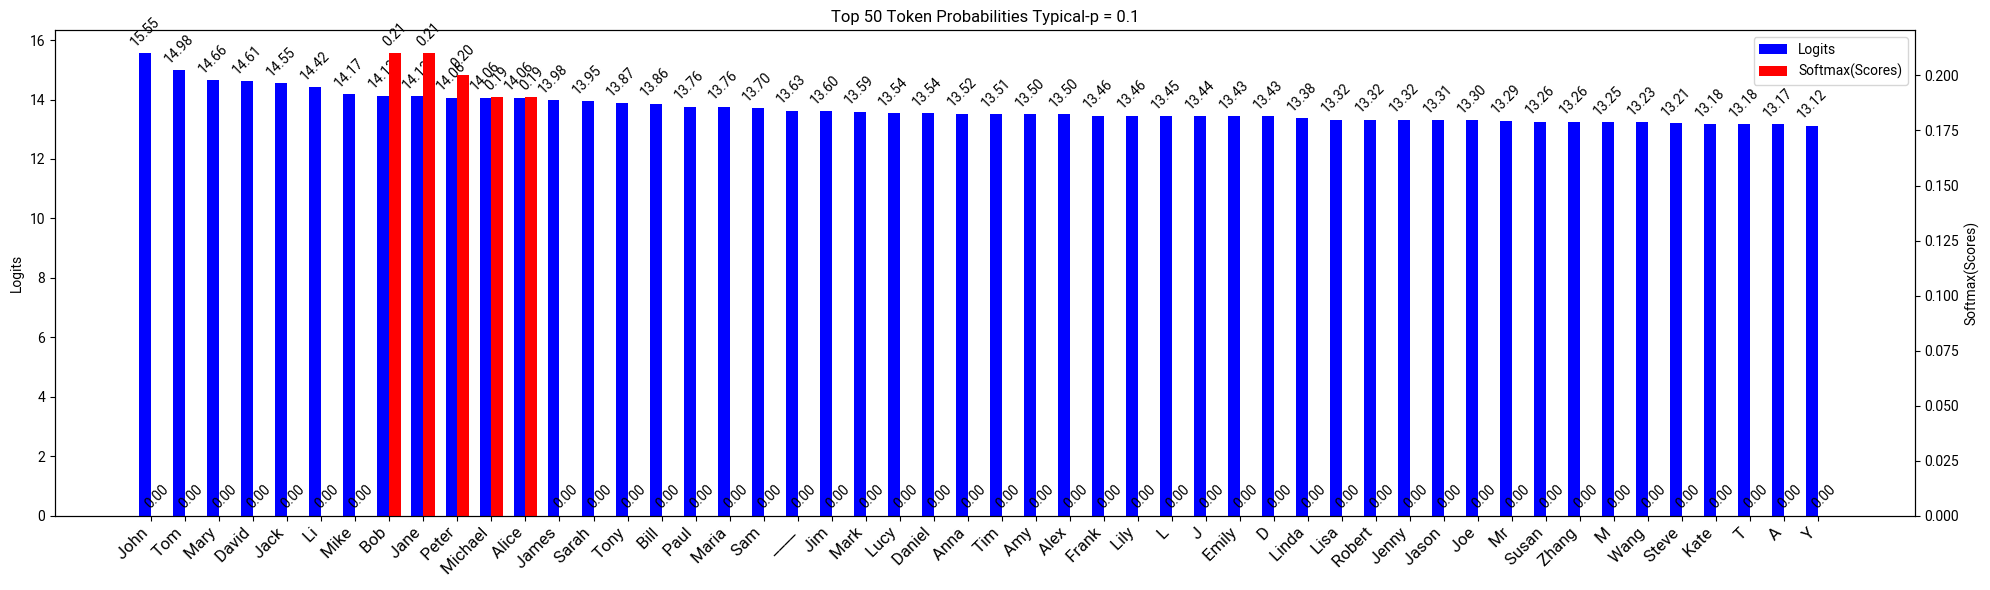

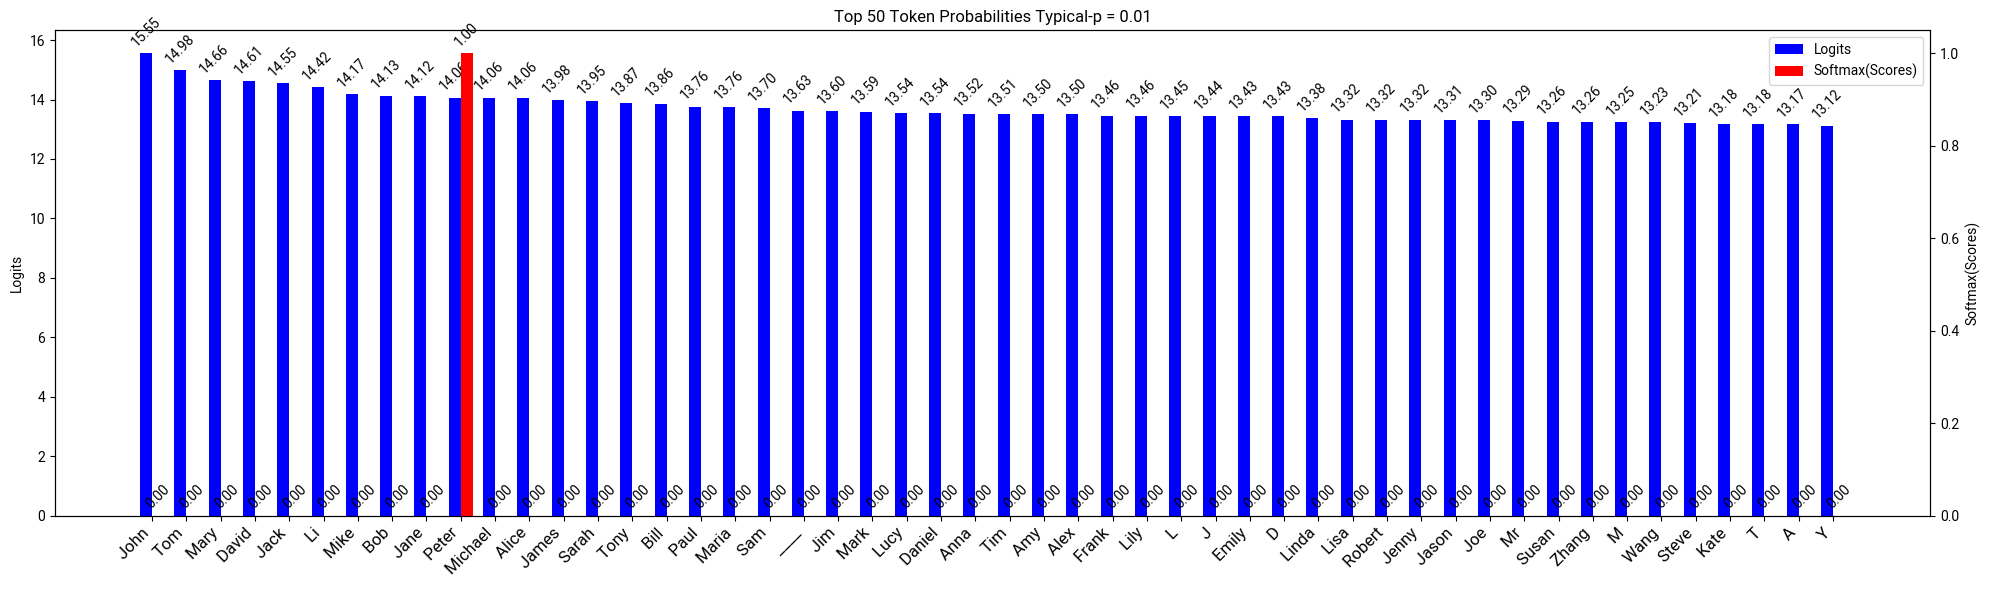

In [23]:
prompt = "My name is"

logits = generate_logits(prompt, do_sample=True, temperature=1, typical_p=0.9)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Typical-p = 0.9')

logits = generate_logits(prompt, do_sample=True, temperature=1, typical_p=0.7)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Typical-p = 0.7')

logits = generate_logits(prompt, do_sample=True, temperature=1, typical_p=0.5)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Typical-p = 0.5')

logits = generate_logits(prompt, do_sample=True, temperature=1, typical_p=0.2)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Typical-p = 0.2')

logits = generate_logits(prompt, do_sample=True, temperature=1, typical_p=0.1)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Typical-p = 0.1')

logits = generate_logits(prompt, do_sample=True, temperature=1, typical_p=0.01)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Typical-p = 0.01')



### Repetition Penalty

The repetition penalty parameter is used to penalize tokens that were previously generated, with a decay factor of `repetition_penalty`.

```
score["token"] = logit["token"] / repetition_penalty ^ min(word_count["token"], 1)
```

A value of 1.0 is equivalent to no repetition penalty. Values greater than 1.0, tipically between 1.1 and 1.5 make the model less likely to repeat tokens.

Example:  
```
With repetition_penalty = 1.0:
"The cat sat on the mat. The cat sat..."

With repetition_penalty = 1.5:
"The cat sat on the mat. The dog walked..."
```

See [this paper](https://arxiv.org/pdf/1909.05858.pdf) for more details.

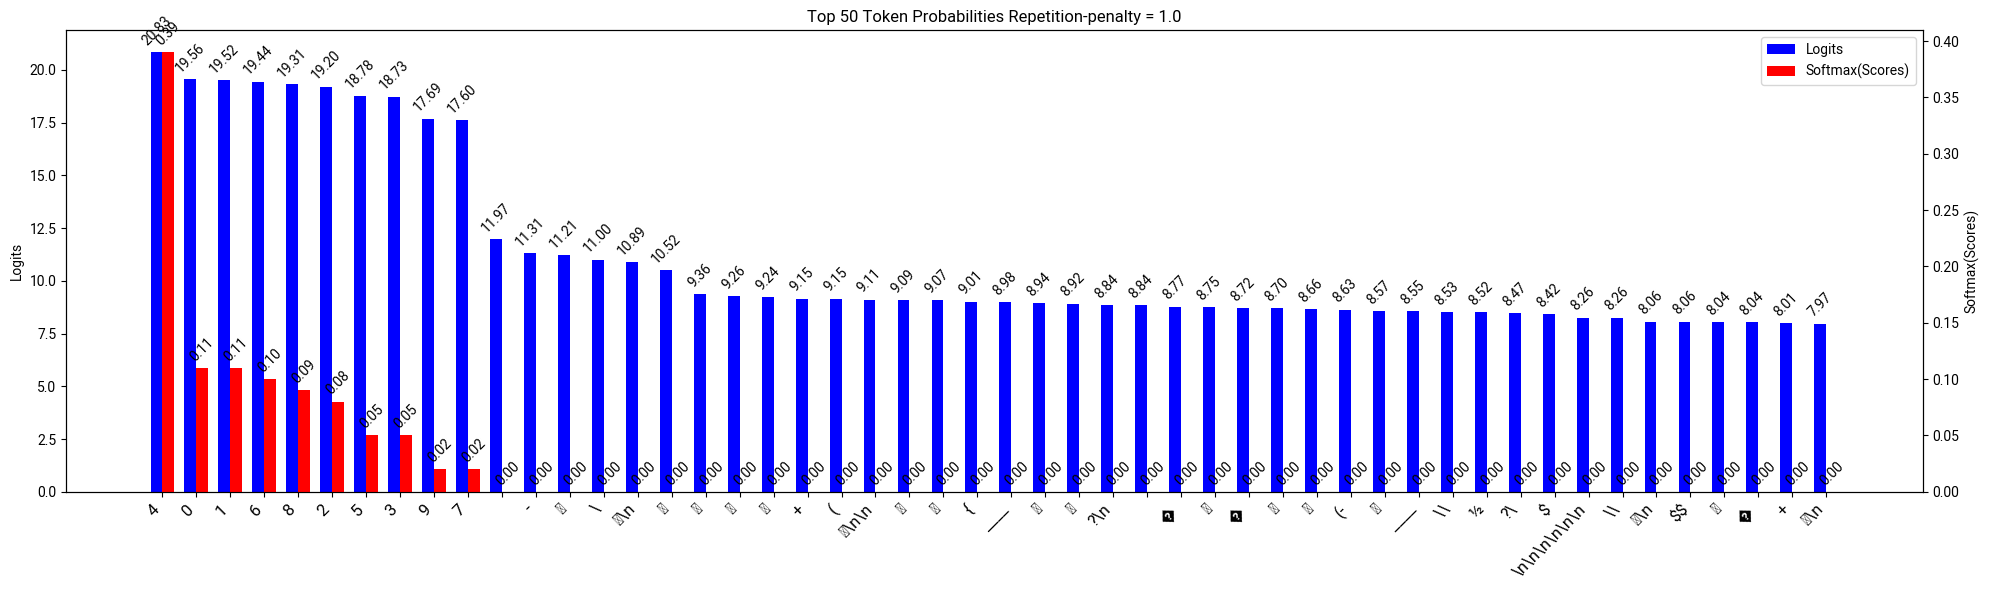

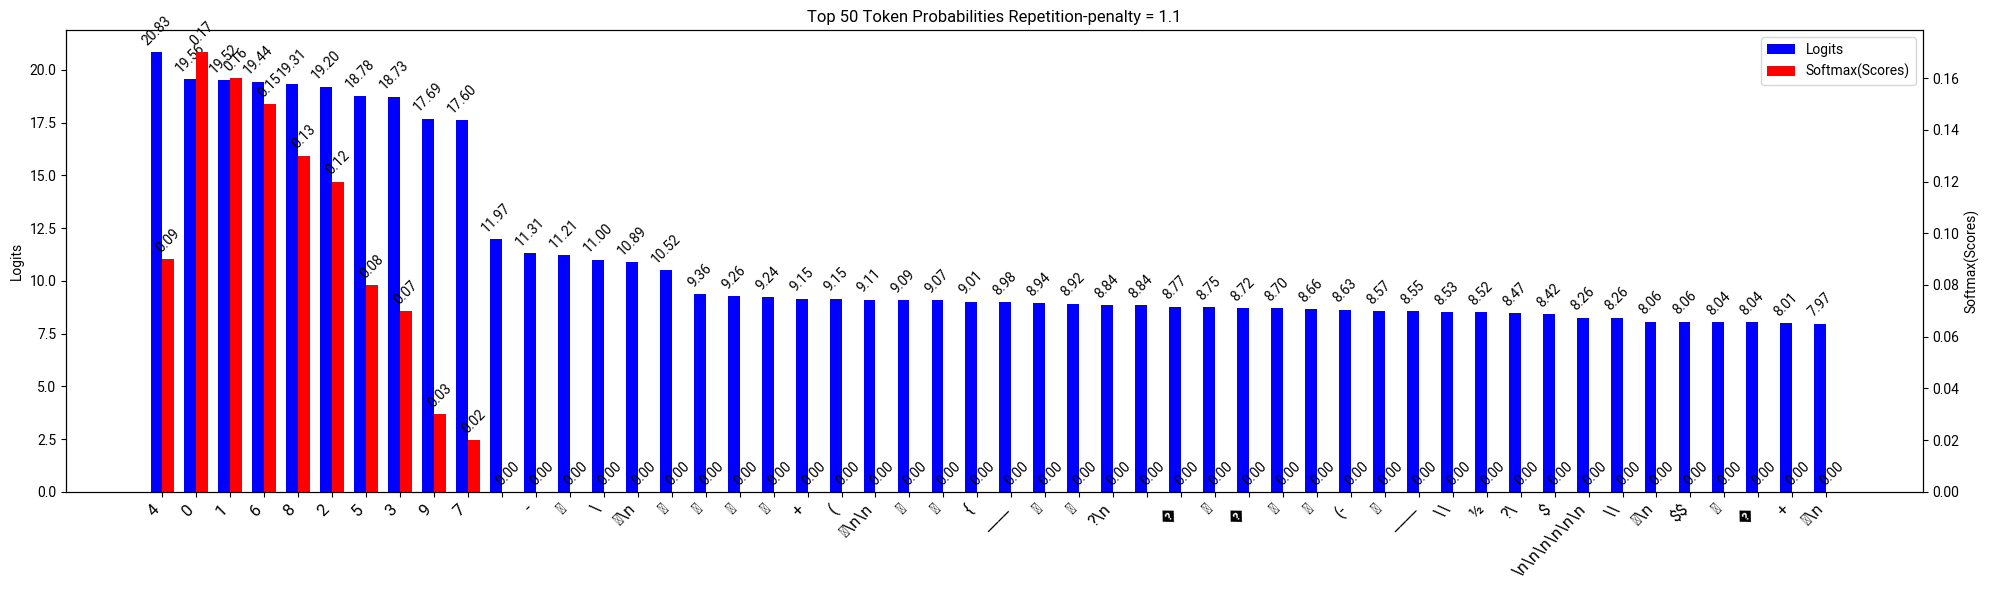

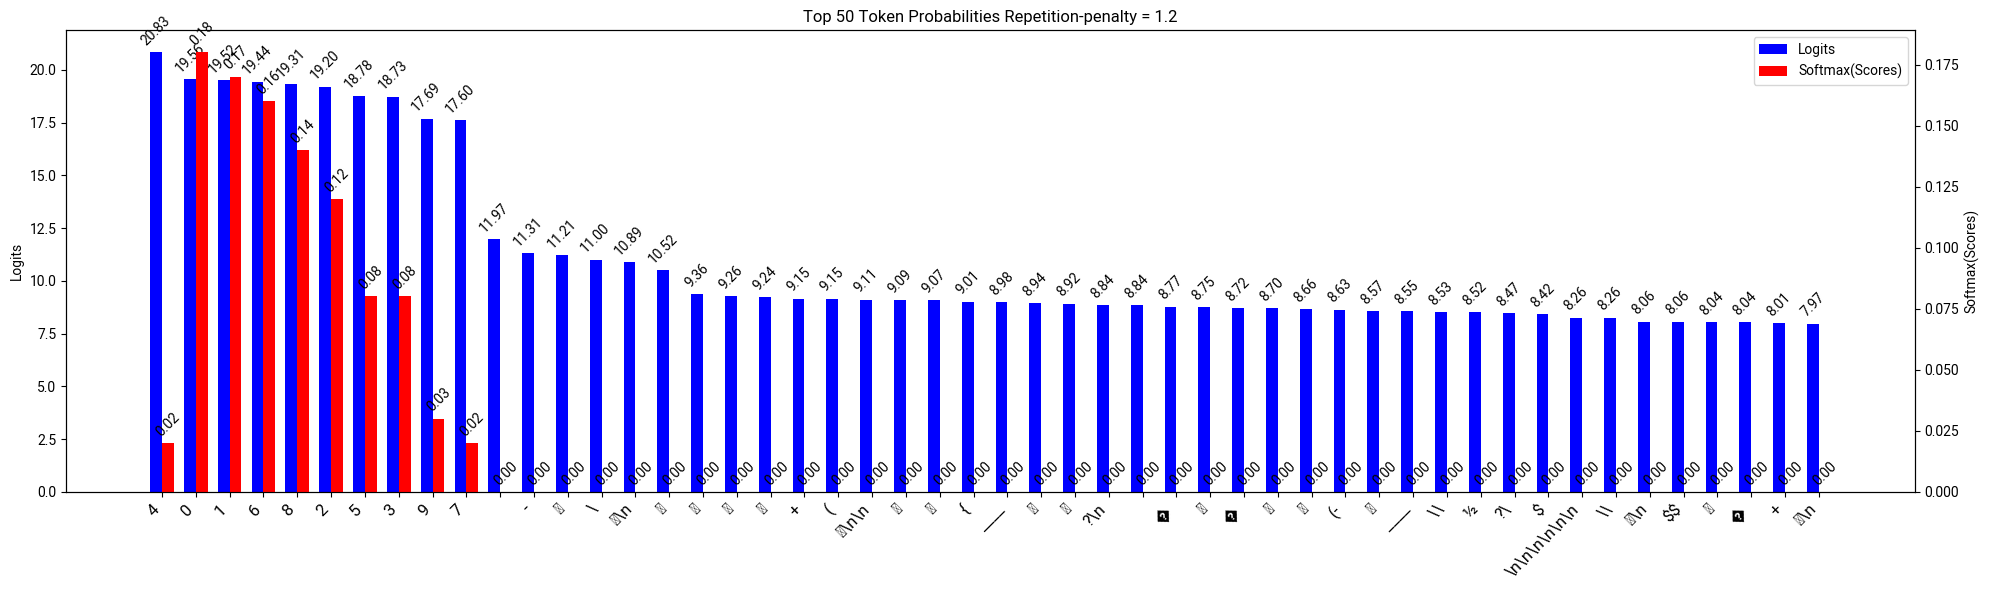

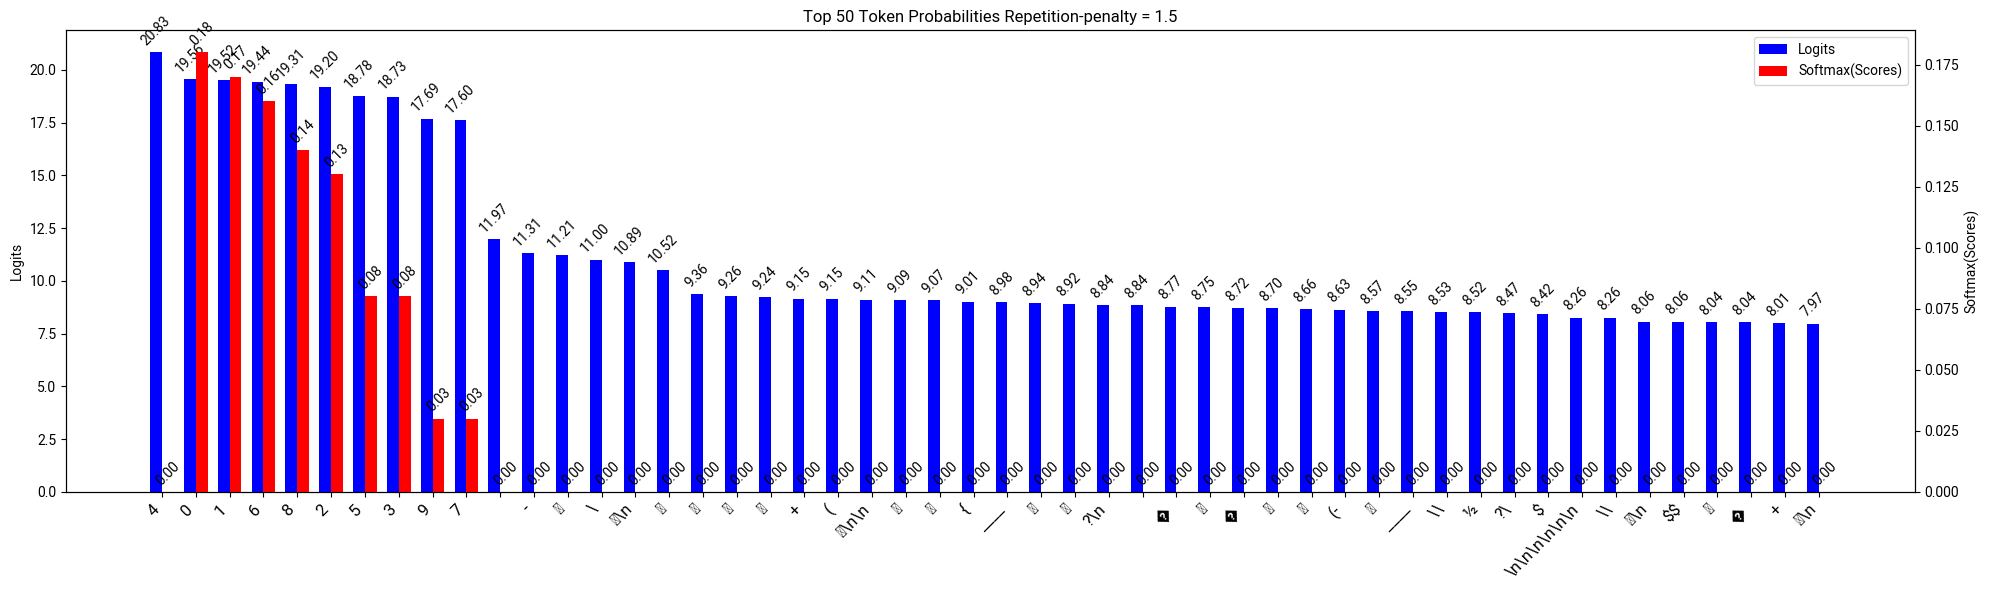

In [24]:
# [Chorus: Eminem]
# Hi, my name is, what? My name is, who?
# My name is, chka-chka, Slim Shady
# prompt = "Hi, my name is, what? My name is, who?" # 

prompt = "4 + 4 - 4 = "
# prompt = "4 + 4 - 4 = 4 is an equiation that is true, uses the same number on both sides of the equal sign. 4 + 1*0 = "

logits = generate_logits(prompt, do_sample=True, temperature=1, repetition_penalty=1.0)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Repetition-penalty = 1.0')

logits = generate_logits(prompt, do_sample=True, temperature=1, repetition_penalty=1.1)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Repetition-penalty = 1.1')

logits = generate_logits(prompt, do_sample=True, temperature=1, repetition_penalty=1.2)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Repetition-penalty = 1.2')

logits = generate_logits(prompt, do_sample=True, temperature=1, repetition_penalty=1.5)
visualize_top_k_tokens(logits['logits'], logits['scores'], 50, name='Repetition-penalty = 1.5')



## Beam search decoding strategy

Beam Search is like exploring multiple possible paths forward at the same time, keeping track of the most promising ones.   
Think of it like writing a story where you consider several different ways it could continue at each step.  

Here's how it works:  
1. Start with a prompt:  
   Let's say we start with `The cat`  
    
2. Consider multiple possibilities:  
   Instead of just picking the single most likely next word (like in greedy search), beam search keeps track of several options.   
   The number of paths we keep is called the "beam width"  

   For example, with a beam width of 2:
   ```
   The cat [sat] → score: 0.8 ✅
   The cat [was] → score: 0.7 ✅
   The cat [jumped] → score: 0.6 ❌
   ...
   ```

3. Expand each possibility:  
   For each of these paths, we again consider multiple options:  
   ```
   The cat sat [on] → score: 0.72 ✅
   The cat sat [by] → score: 0.64 ❌
   The cat sat [under] → score: 0.56 ❌
   ...

   The cat was [sleeping] → score: 0.70 ✅
   The cat was [hungry] → score: 0.56 ❌
   The cat was [black] → score: 0.49 ❌
   ...
   ```
   <img src="./.images/beam-search-graph.png" style="max-width: 500px"/>


4. Keep the best overall:  
   After each step, we keep only the top N paths (where N is our beam width)

---

Advantages:  
- More likely to find good overall sequences than greedy search
- Can generate multiple different outputs
- Less likely to get stuck in poor choices

Disadvantages:  
- Takes more computation than simpler methods
- Can sometimes produce very similar outputs if paths converge

Think of it like a chess player considering several possible moves ahead, but only focusing on the most promising sequences rather than every possible combination.

Here's an example of the prompt `My name is` with a beam width of 5:  

<img src="./.images/beam-search-spread.png"/>


---

We will be implementing beam search in the next section.

This is a simplified version of the beam search algorithm implemented in the `transformers` library.  
It is only meant to showcase the beam search process, and only supports simple beam search, not constrained or grouped beam search.

Refereces:  
[Beam search](https://huggingface.co/blog/how-to-generate#beam-search)  
[Constrained beam search](https://huggingface.co/blog/constrained-beam-search)  

Below, we implement a graph node class to store the beam search graph for later visualization.  
This is normally not needed in the context of beam search algorithms, but we will use it for visualization purposes.


In [25]:
from dataclasses import dataclass, field

# create a graph node class to store the beam search graph for later visualization
# this is normally not needed in the context of beam search algorithms, but we will use it for visualization purposes

@dataclass
class BeamNode:
    my_tokens: torch.Tensor
    sequence_tokens: torch.Tensor

    my_score: float
    sequence_score: float
    children: list['BeamNode'] = field(default_factory=list)
    chosen: bool = False

    def add_child(self, child: 'BeamNode'):
        self.children.append(child)

    def text(self):
        return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(self.sequence_tokens))
    
    def my_text(self):
        return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(self.my_tokens))

    def __str__(self):
        return f'{self.score:.10f}: {self.my_text()} ({self.text()})'
    
    def id(self):
        return '_'+'_'.join([str(token) for token in self.sequence_tokens.tolist()])



Now, let's implement the beam search algorithm.

In [26]:
from tqdm import tqdm

def forward_modal_and_sample(model, tokens, top_k=2, temperature=None):
    '''
    Forward pass through the model to generate the logits and sample from them.

    Args:
        model (torch.nn.Module): The model to use for the forward pass.
        tokens (torch.Tensor): The tokens to use for the forward pass.
        top_k (int): The number of top-k tokens to sample from.
        temperature (float): The temperature to use for the sampling.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: A tuple containing the top-k values and the top-k token-indeces.
    '''
    # forward pass through the model to generate the logits
    model_out = model(input_ids=tokens.unsqueeze(0), attention_mask=torch.ones_like(tokens).unsqueeze(0).to(model.device))

    # if temperature is set, we need to scale the logits by the temperature and convert them to probabilities
    if temperature is not None and temperature > 0 and temperature <= 1:
        adjusted = model_out['logits'][:, -1, :] / temperature
        probabilities = adjusted.softmax(dim=-1)
        # Sample from probabilities using multinomial to get indices
        sampled_indices = torch.multinomial(probabilities[0], num_samples=top_k)
        values = probabilities[0][sampled_indices]
        return values, sampled_indices

    # compute probabilities and get the top-k values and token-indeces
    probabilities = model_out['logits'][:, -1, :].softmax(dim=-1)
    values, indeces = probabilities.topk(top_k)
    return values[0], indeces[0]


def token_to_string(tokens):
    '''
    Convert a list of tokens to a string.
    '''
    return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(tokens))

def beam_search(model, start_text, nb_beams=3, iterations=10, temperature=0):
    '''
    Perform beam search algorithm.

    Args:
        model (torch.nn.Module): The model to use for the beam search.
        start_text (str): The text to start the beam search with.
        nb_beams (int): The number of beams to use.
        iterations (int): The number of iterations to perform.
        temperature (float): The temperature to use for the sampling.

    Returns:
        Tuple[List[BeamNode], BeamNode]: A tuple containing the found beams, and the root beam node used for visualization.
    '''

    # encode text to tokens
    start_tokens = tokenizer(start_text, return_tensors="pt").to(model.device)['input_ids'][0]

    # create root beam from which all beams will stem
    root = BeamNode(start_tokens, start_tokens, my_score=1, sequence_score=1, chosen=True)

    # initialize a list of beams processed by the last iteration
    last_processed_beams = [root]

    # iterate over the number of iterations
    for _ in tqdm(list(range(iterations))):

        # initialize a list of next beams to process
        next_beams_to_process = []
        
        # for each beam in the last iteration
        for beam in last_processed_beams:
            
            # generate a list of top-k tokens and their scores
            top_k_values, top_k_indeces = forward_modal_and_sample(model, beam.sequence_tokens, nb_beams, temperature=temperature)

            # for each generated token
            for token, token_score in zip(top_k_indeces, top_k_values):

                # create a new beam with the current token
                next_beam = BeamNode(
                    my_tokens=token.unsqueeze(0), 
                    sequence_tokens=torch.cat([beam.sequence_tokens, token.unsqueeze(0)]), 
                    sequence_score=beam.sequence_score * token_score,
                    my_score=token_score,
                    chosen=False
                )

                # add the new beam to the list of next beams to process
                next_beams_to_process.append(next_beam)

                # add the new beam as a child to the current beam processing
                beam.add_child(next_beam)

        # sort the iteration of beams by their sequence score
        next_beams_to_process = sorted(next_beams_to_process, key=lambda x: x.sequence_score, reverse=True)

        # keep top nb_beams
        last_processed_beams = next_beams_to_process[:nb_beams]

        # mark the chosen beam
        for beam in last_processed_beams:
            beam.chosen = True

    # return the found beams, and the root beam used for visualization
    return last_processed_beams, root


Let's test the beam search algorithm with the prompt `My name is`.

In [27]:
# set torch seed
torch.manual_seed(0)

beams, root_beam = beam_search(model, "My name is", nb_beams=5, iterations=5)
for beam in beams:
    print(beam.text())
    print('---')


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 13.82it/s]

My name is John Smith. I am
---
My name is John. I am a
---
My name is John. I am 
---
My name is Tom. I am a
---
My name is Jack. I am a
---


Now, let's visualize the beam search as a graph, who's root is the prompt we used and leafes are the generated outputs.  

The nodes are color coded to indicate their role in the beam search process:
- `grey`: nodes that we've passed through
- `green`: a chosen output beam
- `red`: a discarded / pruned beam

We will also visualize the token's probability of being chosen, as well as the entire beam's probability of being chosen.  
You will notice that the beam's probability is the product of the probabilities of all the tokens in the beam.  
Since the search is exponential, the beam's probability is shrinking very fast.

In [32]:
from IPython.display import Markdown, display

def show_beam_search(root_beam: BeamNode, out_beams: list[BeamNode]):
    """
    Visualize the beam search process using mermaid.js syntax.
    """

    # initialize the mermaid text
    mermaid_text = """
flowchart LR
    %% Configure direction and layout
    direction LR
    classDef discarded fill:#5e1300
    classDef output fill:#004713
    """

    # process each beam and add its children to the mermaid text
    def process_beam(beam: BeamNode, iteration: int):
        nonlocal mermaid_text
        
        # if beam.children:
        #     mermaid_text += f'    subgraph level_{iteration}[Level {iteration}]\n'

        for child in beam.children:
            clean_beam_text = beam.my_text().replace('"', '').replace('[', '').replace(']', '').replace('\n', '\\n').replace('(', '\\(').replace(')', '\\)') or " "
            clean_child_text = child.my_text().replace('"', '').replace('[', '').replace(']', '').replace('\n', '\\n').replace('(', '\\(').replace(')', '\\)') or " "
            mermaid_text += f'    {beam.id()}["{clean_beam_text}"] -->|Beam: {child.sequence_score:.10f}\nToken: {child.my_score:.10f}| {child.id()}["{clean_child_text}"]{":::discarded" if not child.chosen else ""}'
            mermaid_text += '\n'

            process_beam(child, iteration + 1)

        # if beam.children:
        #     mermaid_text += f'    end\n'

    # process the root beam
    process_beam(root_beam, 0)

    # add the leaf beams to the mermaid text for easy visualization
    for out_beam_idx, beam in enumerate(out_beams):
        mermaid_text += f'    {beam.id()}["{beam.my_text()}"] -->|Output beam {out_beam_idx}| _out_{out_beam_idx}["{beam.text()}"]:::output'
        mermaid_text += '\n'

    # show markdown
    display(Markdown(f'''
```mermaid
{mermaid_text}
```
    '''))

    return mermaid_text

show_beam_search(root_beam, beams)
None


```mermaid

flowchart LR
    %% Configure direction and layout
    direction LR
    classDef discarded fill:#5e1300
    classDef output fill:#004713
        _5050_829_374["My name is"] -->|Beam: 0.0411566421
Token: 0.0411566421| _5050_829_374_3757[" John"]
    _5050_829_374_3757[" John"] -->|Beam: 0.0094364630
Token: 0.2292816639| _5050_829_374_3757_13["."]
    _5050_829_374_3757_13["."] -->|Beam: 0.0051072114
Token: 0.5412209630| _5050_829_374_3757_13_358[" I"]
    _5050_829_374_3757_13_358[" I"] -->|Beam: 0.0015955335
Token: 0.3124079406| _5050_829_374_3757_13_358_1079[" am"]
    _5050_829_374_3757_13_358_1079[" am"] -->|Beam: 0.0004615824
Token: 0.2892966270| _5050_829_374_3757_13_358_1079_264[" a"]
    _5050_829_374_3757_13_358_1079[" am"] -->|Beam: 0.0003415350
Token: 0.2140569538| _5050_829_374_3757_13_358_1079_220[" "]
    _5050_829_374_3757_13_358_1079[" am"] -->|Beam: 0.0001389662
Token: 0.0870970190| _5050_829_374_3757_13_358_1079_458[" an"]:::discarded
    _5050_829_374_3757_13_358_1079[" am"] -->|Beam: 0.0001263589
Token: 0.0791954100| _5050_829_374_3757_13_358_1079_504[" from"]:::discarded
    _5050_829_374_3757_13_358_1079[" am"] -->|Beam: 0.0000478028
Token: 0.0299603976| _5050_829_374_3757_13_358_1079_304[" in"]:::discarded
    _5050_829_374_3757_13_358[" I"] -->|Beam: 0.0009074046
Token: 0.1776712537| _5050_829_374_3757_13_358_2776["'m"]
    _5050_829_374_3757_13_358_2776["'m"] -->|Beam: 0.0002342699
Token: 0.2581757605| _5050_829_374_3757_13_358_2776_264[" a"]:::discarded
    _5050_829_374_3757_13_358_2776["'m"] -->|Beam: 0.0001624502
Token: 0.1790273041| _5050_829_374_3757_13_358_2776_220[" "]:::discarded
    _5050_829_374_3757_13_358_2776["'m"] -->|Beam: 0.0001033629
Token: 0.1139104739| _5050_829_374_3757_13_358_2776_504[" from"]:::discarded
    _5050_829_374_3757_13_358_2776["'m"] -->|Beam: 0.0000912545
Token: 0.1005664989| _5050_829_374_3757_13_358_2776_458[" an"]:::discarded
    _5050_829_374_3757_13_358_2776["'m"] -->|Beam: 0.0000342968
Token: 0.0377966128| _5050_829_374_3757_13_358_2776_304[" in"]:::discarded
    _5050_829_374_3757_13_358[" I"] -->|Beam: 0.0005643130
Token: 0.1104933769| _5050_829_374_3757_13_358_614[" have"]:::discarded
    _5050_829_374_3757_13_358[" I"] -->|Beam: 0.0002996803
Token: 0.0586778782| _5050_829_374_3757_13_358_4249["’m"]:::discarded
    _5050_829_374_3757_13_358[" I"] -->|Beam: 0.0002174625
Token: 0.0425794944| _5050_829_374_3757_13_358_3887[" live"]:::discarded
    _5050_829_374_3757_13["."] -->|Beam: 0.0007594306
Token: 0.0804783106| _5050_829_374_3757_13_3017[" My"]:::discarded
    _5050_829_374_3757_13["."] -->|Beam: 0.0003413431
Token: 0.0361727811| _5050_829_374_3757_13_1096[" This"]:::discarded
    _5050_829_374_3757_13["."] -->|Beam: 0.0001402583
Token: 0.0148634408| _5050_829_374_3757_13_11201[" Today"]:::discarded
    _5050_829_374_3757_13["."] -->|Beam: 0.0001202080
Token: 0.0127386674| _5050_829_374_3757_13_1084[" It"]:::discarded
    _5050_829_374_3757[" John"] -->|Beam: 0.0080525829
Token: 0.1956569403| _5050_829_374_3757_9082[" Smith"]
    _5050_829_374_3757_9082[" Smith"] -->|Beam: 0.0037131240
Token: 0.4611096978| _5050_829_374_3757_9082_13["."]
    _5050_829_374_3757_9082_13["."] -->|Beam: 0.0015313682
Token: 0.4124204516| _5050_829_374_3757_9082_13_358[" I"]
    _5050_829_374_3757_9082_13_358[" I"] -->|Beam: 0.0005084158
Token: 0.3320010006| _5050_829_374_3757_9082_13_358_1079[" am"]
    _5050_829_374_3757_9082_13_358[" I"] -->|Beam: 0.0002384797
Token: 0.1557298452| _5050_829_374_3757_9082_13_358_2776["'m"]:::discarded
    _5050_829_374_3757_9082_13_358[" I"] -->|Beam: 0.0001708409
Token: 0.1115609780| _5050_829_374_3757_9082_13_358_614[" have"]:::discarded
    _5050_829_374_3757_9082_13_358[" I"] -->|Beam: 0.0000993350
Token: 0.0648668557| _5050_829_374_3757_9082_13_358_4249["’m"]:::discarded
    _5050_829_374_3757_9082_13_358[" I"] -->|Beam: 0.0000612467
Token: 0.0399947315| _5050_829_374_3757_9082_13_358_572[" was"]:::discarded
    _5050_829_374_3757_9082_13["."] -->|Beam: 0.0003692809
Token: 0.0994528756| _5050_829_374_3757_9082_13_3017[" My"]:::discarded
    _5050_829_374_3757_9082_13["."] -->|Beam: 0.0001343521
Token: 0.0361830480| _5050_829_374_3757_9082_13_1096[" This"]:::discarded
    _5050_829_374_3757_9082_13["."] -->|Beam: 0.0000975201
Token: 0.0262636226| _5050_829_374_3757_9082_13_5209[" Please"]:::discarded
    _5050_829_374_3757_9082_13["."] -->|Beam: 0.0000638560
Token: 0.0171973668| _5050_829_374_3757_9082_13_576[" The"]:::discarded
    _5050_829_374_3757_9082[" Smith"] -->|Beam: 0.0013891482
Token: 0.1725096405| _5050_829_374_3757_9082_323[" and"]:::discarded
    _5050_829_374_3757_9082[" Smith"] -->|Beam: 0.0006775347
Token: 0.0841388032| _5050_829_374_3757_9082_11[","]:::discarded
    _5050_829_374_3757_9082[" Smith"] -->|Beam: 0.0006073811
Token: 0.0754268616| _5050_829_374_3757_9082_58883["．"]:::discarded
    _5050_829_374_3757_9082[" Smith"] -->|Beam: 0.0003359905
Token: 0.0417245664| _5050_829_374_3757_9082_3837["，"]:::discarded
    _5050_829_374_3757[" John"] -->|Beam: 0.0041125901
Token: 0.0999253020| _5050_829_374_3757_323[" and"]:::discarded
    _5050_829_374_3757[" John"] -->|Beam: 0.0028646889
Token: 0.0696045309| _5050_829_374_3757_58883["．"]:::discarded
    _5050_829_374_3757[" John"] -->|Beam: 0.0017615004
Token: 0.0427999049| _5050_829_374_3757_11[","]:::discarded
    _5050_829_374["My name is"] -->|Beam: 0.0233966000
Token: 0.0233966000| _5050_829_374_8364[" Tom"]
    _5050_829_374_8364[" Tom"] -->|Beam: 0.0065380842
Token: 0.2794459164| _5050_829_374_8364_13["."]
    _5050_829_374_8364_13["."] -->|Beam: 0.0037122231
Token: 0.5677845478| _5050_829_374_8364_13_358[" I"]
    _5050_829_374_8364_13_358[" I"] -->|Beam: 0.0010794305
Token: 0.2907773554| _5050_829_374_8364_13_358_1079[" am"]
    _5050_829_374_8364_13_358_1079[" am"] -->|Beam: 0.0003096888
Token: 0.2869001627| _5050_829_374_8364_13_358_1079_264[" a"]
    _5050_829_374_8364_13_358_1079[" am"] -->|Beam: 0.0001624591
Token: 0.1505044699| _5050_829_374_8364_13_358_1079_220[" "]:::discarded
    _5050_829_374_8364_13_358_1079[" am"] -->|Beam: 0.0001167394
Token: 0.1081490368| _5050_829_374_8364_13_358_1079_458[" an"]:::discarded
    _5050_829_374_8364_13_358_1079[" am"] -->|Beam: 0.0000959078
Token: 0.0888504088| _5050_829_374_8364_13_358_1079_504[" from"]:::discarded
    _5050_829_374_8364_13_358_1079[" am"] -->|Beam: 0.0000505670
Token: 0.0468459725| _5050_829_374_8364_13_358_1079_304[" in"]:::discarded
    _5050_829_374_8364_13_358[" I"] -->|Beam: 0.0008383379
Token: 0.2258317620| _5050_829_374_8364_13_358_2776["'m"]:::discarded
    _5050_829_374_8364_13_358[" I"] -->|Beam: 0.0004935540
Token: 0.1329537630| _5050_829_374_8364_13_358_614[" have"]:::discarded
    _5050_829_374_8364_13_358[" I"] -->|Beam: 0.0001844502
Token: 0.0496872552| _5050_829_374_8364_13_358_3887[" live"]:::discarded
    _5050_829_374_8364_13_358[" I"] -->|Beam: 0.0001795164
Token: 0.0483581796| _5050_829_374_8364_13_358_4249["’m"]:::discarded
    _5050_829_374_8364_13["."] -->|Beam: 0.0003877026
Token: 0.0592991151| _5050_829_374_8364_13_3017[" My"]:::discarded
    _5050_829_374_8364_13["."] -->|Beam: 0.0003446050
Token: 0.0527073368| _5050_829_374_8364_13_1096[" This"]:::discarded
    _5050_829_374_8364_13["."] -->|Beam: 0.0001503089
Token: 0.0229897499| _5050_829_374_8364_13_9909["（"]:::discarded
    _5050_829_374_8364_13["."] -->|Beam: 0.0001027572
Token: 0.0157167185| _5050_829_374_8364_13_42344[" （"]:::discarded
    _5050_829_374_8364[" Tom"] -->|Beam: 0.0036406028
Token: 0.1556039304| _5050_829_374_8364_58883["．"]:::discarded
    _5050_829_374_8364[" Tom"] -->|Beam: 0.0016898919
Token: 0.0722280964| _5050_829_374_8364_323[" and"]:::discarded
    _5050_829_374_8364[" Tom"] -->|Beam: 0.0014838793
Token: 0.0634228587| _5050_829_374_8364_9082[" Smith"]:::discarded
    _5050_829_374_8364[" Tom"] -->|Beam: 0.0010782785
Token: 0.0460869744| _5050_829_374_8364_3837["，"]:::discarded
    _5050_829_374["My name is"] -->|Beam: 0.0169419535
Token: 0.0169419535| _5050_829_374_10244[" Mary"]
    _5050_829_374_10244[" Mary"] -->|Beam: 0.0043943310
Token: 0.2593756914| _5050_829_374_10244_13["."]
    _5050_829_374_10244_13["."] -->|Beam: 0.0027232757
Token: 0.6197247505| _5050_829_374_10244_13_358[" I"]
    _5050_829_374_10244_13_358[" I"] -->|Beam: 0.0008049258
Token: 0.2955726385| _5050_829_374_10244_13_358_1079[" am"]:::discarded
    _5050_829_374_10244_13_358[" I"] -->|Beam: 0.0005264374
Token: 0.1933103353| _5050_829_374_10244_13_358_2776["'m"]:::discarded
    _5050_829_374_10244_13_358[" I"] -->|Beam: 0.0003567452
Token: 0.1309985518| _5050_829_374_10244_13_358_614[" have"]:::discarded
    _5050_829_374_10244_13_358[" I"] -->|Beam: 0.0001402507
Token: 0.0515007451| _5050_829_374_10244_13_358_3887[" live"]:::discarded
    _5050_829_374_10244_13_358[" I"] -->|Beam: 0.0001339687
Token: 0.0491939373| _5050_829_374_10244_13_358_4249["’m"]:::discarded
    _5050_829_374_10244_13["."] -->|Beam: 0.0002790616
Token: 0.0635049120| _5050_829_374_10244_13_3017[" My"]:::discarded
    _5050_829_374_10244_13["."] -->|Beam: 0.0001797785
Token: 0.0409114696| _5050_829_374_10244_13_1096[" This"]:::discarded
    _5050_829_374_10244_13["."] -->|Beam: 0.0000633834
Token: 0.0144238938| _5050_829_374_10244_13_5692[" Here"]:::discarded
    _5050_829_374_10244_13["."] -->|Beam: 0.0000536749
Token: 0.0122145778| _5050_829_374_10244_13_9909["（"]:::discarded
    _5050_829_374_10244[" Mary"] -->|Beam: 0.0020183939
Token: 0.1191358417| _5050_829_374_10244_9082[" Smith"]:::discarded
    _5050_829_374_10244[" Mary"] -->|Beam: 0.0014366462
Token: 0.0847981423| _5050_829_374_10244_323[" and"]:::discarded
    _5050_829_374_10244[" Mary"] -->|Beam: 0.0011305526
Token: 0.0667309463| _5050_829_374_10244_58883["．"]:::discarded
    _5050_829_374_10244[" Mary"] -->|Beam: 0.0006669146
Token: 0.0393646844| _5050_829_374_10244_11[","]:::discarded
    _5050_829_374["My name is"] -->|Beam: 0.0161250904
Token: 0.0161250904| _5050_829_374_6798[" David"]
    _5050_829_374_6798[" David"] -->|Beam: 0.0032926134
Token: 0.2041919380| _5050_829_374_6798_13["."]:::discarded
    _5050_829_374_6798[" David"] -->|Beam: 0.0016448339
Token: 0.1020046324| _5050_829_374_6798_323[" and"]:::discarded
    _5050_829_374_6798[" David"] -->|Beam: 0.0010010655
Token: 0.0620812327| _5050_829_374_6798_11[","]:::discarded
    _5050_829_374_6798[" David"] -->|Beam: 0.0006185463
Token: 0.0383592471| _5050_829_374_6798_9082[" Smith"]:::discarded
    _5050_829_374_6798[" David"] -->|Beam: 0.0004227023
Token: 0.0262139495| _5050_829_374_6798_58883["．"]:::discarded
    _5050_829_374["My name is"] -->|Beam: 0.0152853290
Token: 0.0152853290| _5050_829_374_7607[" Jack"]
    _5050_829_374_7607[" Jack"] -->|Beam: 0.0053937123
Token: 0.3528685868| _5050_829_374_7607_13["."]
    _5050_829_374_7607_13["."] -->|Beam: 0.0031682649
Token: 0.5873996615| _5050_829_374_7607_13_358[" I"]
    _5050_829_374_7607_13_358[" I"] -->|Beam: 0.0009475061
Token: 0.2990615070| _5050_829_374_7607_13_358_1079[" am"]
    _5050_829_374_7607_13_358_1079[" am"] -->|Beam: 0.0002866780
Token: 0.3025605977| _5050_829_374_7607_13_358_1079_264[" a"]
    _5050_829_374_7607_13_358_1079[" am"] -->|Beam: 0.0001531845
Token: 0.1616712511| _5050_829_374_7607_13_358_1079_220[" "]:::discarded
    _5050_829_374_7607_13_358_1079[" am"] -->|Beam: 0.0000864640
Token: 0.0912543163| _5050_829_374_7607_13_358_1079_504[" from"]:::discarded
    _5050_829_374_7607_13_358_1079[" am"] -->|Beam: 0.0000846717
Token: 0.0893627331| _5050_829_374_7607_13_358_1079_458[" an"]:::discarded
    _5050_829_374_7607_13_358_1079[" am"] -->|Beam: 0.0000356209
Token: 0.0375944041| _5050_829_374_7607_13_358_1079_29235[" twelve"]:::discarded
    _5050_829_374_7607_13_358[" I"] -->|Beam: 0.0007535584
Token: 0.2378457785| _5050_829_374_7607_13_358_2776["'m"]:::discarded
    _5050_829_374_7607_13_358[" I"] -->|Beam: 0.0003679990
Token: 0.1161516011| _5050_829_374_7607_13_358_614[" have"]:::discarded
    _5050_829_374_7607_13_358[" I"] -->|Beam: 0.0001667116
Token: 0.0526192226| _5050_829_374_7607_13_358_3887[" live"]:::discarded
    _5050_829_374_7607_13_358[" I"] -->|Beam: 0.0001425242
Token: 0.0449849442| _5050_829_374_7607_13_358_4249["’m"]:::discarded
    _5050_829_374_7607_13["."] -->|Beam: 0.0003242462
Token: 0.0601155981| _5050_829_374_7607_13_3017[" My"]:::discarded
    _5050_829_374_7607_13["."] -->|Beam: 0.0002582362
Token: 0.0478772633| _5050_829_374_7607_13_1096[" This"]:::discarded
    _5050_829_374_7607_13["."] -->|Beam: 0.0001329694
Token: 0.0246526729| _5050_829_374_7607_13_7607[" Jack"]:::discarded
    _5050_829_374_7607_13["."] -->|Beam: 0.0001045604
Token: 0.0193856042| _5050_829_374_7607_13_11201[" Today"]:::discarded
    _5050_829_374_7607[" Jack"] -->|Beam: 0.0015294140
Token: 0.1000576392| _5050_829_374_7607_323[" and"]:::discarded
    _5050_829_374_7607[" Jack"] -->|Beam: 0.0008356746
Token: 0.0546716787| _5050_829_374_7607_58883["．"]:::discarded
    _5050_829_374_7607[" Jack"] -->|Beam: 0.0007785200
Token: 0.0509324968| _5050_829_374_7607_9082[" Smith"]:::discarded
    _5050_829_374_7607[" Jack"] -->|Beam: 0.0007304471
Token: 0.0477874614| _5050_829_374_7607_11[","]:::discarded
    _5050_829_374_3757_9082_13_358_1079[" am"] -->|Output beam 0| _out_0["My name is John Smith. I am"]:::output
    _5050_829_374_3757_13_358_1079_264[" a"] -->|Output beam 1| _out_1["My name is John. I am a"]:::output
    _5050_829_374_3757_13_358_1079_220[" "] -->|Output beam 2| _out_2["My name is John. I am "]:::output
    _5050_829_374_8364_13_358_1079_264[" a"] -->|Output beam 3| _out_3["My name is Tom. I am a"]:::output
    _5050_829_374_7607_13_358_1079_264[" a"] -->|Output beam 4| _out_4["My name is Jack. I am a"]:::output

```
    

We can also visualize the beam search as a radial tree, expanding outwards from the root beam at the center.

Each color indicates a trunk stemming from the root beam.  
The width of the trunk indicates the step number. Thinner trunks have had more steps to expand.  
The output leafs are indicated by the "OUTPUT:" label, the other leafs are discarded beams.

In [33]:
from IPython.display import Markdown, display

def show_beam_search(root_beam: BeamNode, out_beams: list[BeamNode]):
    """
    Visualize the beam search process using mermaid.js mindmap syntax.
    """
    # initialize the mermaid text
    mermaid_text = f"""
mindmap
  root(({root_beam.text()}))
"""

    def process_beam(beam: BeamNode, indent_level: int):
        nonlocal mermaid_text
        indent = "  " * indent_level  # Mindmap requires 2 spaces for indentation

        for child in beam.children:
            # Clean and format the text to avoid special characters
            clean_text = child.my_text().replace('"', '').replace('[', '').replace(']', '').replace('\n', '\\n') or " "
            score = f"{child.sequence_score:.4f}"
            
            # Each line must start with indent + one of these symbols: + - * etc
            mermaid_text += f'{indent}  + node["{clean_text}"]\n'
            
            process_beam(child, indent_level + 1)

        if beam.chosen and len(beam.children) == 0:
            clean_text = beam.text().replace('"', '').replace('[', '').replace(']', '').replace('\n', '\\n') or " "
            mermaid_text += f'{indent}  + output["OUTPUT: {clean_text}"]\n'

    # process the root beam's children
    process_beam(root_beam, 1)

    # show markdown
    display(Markdown(f'''
```mermaid
{mermaid_text}
```
    '''))

    return mermaid_text

show_beam_search(root_beam, beams)
None


```mermaid

mindmap
  root((My name is))
    + node[" John"]
      + node["."]
        + node[" I"]
          + node[" am"]
            + node[" a"]
              + output["OUTPUT: My name is John. I am a"]
            + node[" "]
              + output["OUTPUT: My name is John. I am "]
            + node[" an"]
            + node[" from"]
            + node[" in"]
          + node["'m"]
            + node[" a"]
            + node[" "]
            + node[" from"]
            + node[" an"]
            + node[" in"]
          + node[" have"]
          + node["’m"]
          + node[" live"]
        + node[" My"]
        + node[" This"]
        + node[" Today"]
        + node[" It"]
      + node[" Smith"]
        + node["."]
          + node[" I"]
            + node[" am"]
              + output["OUTPUT: My name is John Smith. I am"]
            + node["'m"]
            + node[" have"]
            + node["’m"]
            + node[" was"]
          + node[" My"]
          + node[" This"]
          + node[" Please"]
          + node[" The"]
        + node[" and"]
        + node[","]
        + node["．"]
        + node["，"]
      + node[" and"]
      + node["．"]
      + node[","]
    + node[" Tom"]
      + node["."]
        + node[" I"]
          + node[" am"]
            + node[" a"]
              + output["OUTPUT: My name is Tom. I am a"]
            + node[" "]
            + node[" an"]
            + node[" from"]
            + node[" in"]
          + node["'m"]
          + node[" have"]
          + node[" live"]
          + node["’m"]
        + node[" My"]
        + node[" This"]
        + node["（"]
        + node[" （"]
      + node["．"]
      + node[" and"]
      + node[" Smith"]
      + node["，"]
    + node[" Mary"]
      + node["."]
        + node[" I"]
          + node[" am"]
          + node["'m"]
          + node[" have"]
          + node[" live"]
          + node["’m"]
        + node[" My"]
        + node[" This"]
        + node[" Here"]
        + node["（"]
      + node[" Smith"]
      + node[" and"]
      + node["．"]
      + node[","]
    + node[" David"]
      + node["."]
      + node[" and"]
      + node[","]
      + node[" Smith"]
      + node["．"]
    + node[" Jack"]
      + node["."]
        + node[" I"]
          + node[" am"]
            + node[" a"]
              + output["OUTPUT: My name is Jack. I am a"]
            + node[" "]
            + node[" from"]
            + node[" an"]
            + node[" twelve"]
          + node["'m"]
          + node[" have"]
          + node[" live"]
          + node["’m"]
        + node[" My"]
        + node[" This"]
        + node[" Jack"]
        + node[" Today"]
      + node[" and"]
      + node["．"]
      + node[" Smith"]
      + node[","]

```
    

---
Here's a quick example of how to use beam search with the `generate` method of the `transformers` library.

In [34]:
inputs = tokenizer("My name is", return_tensors="pt").to(model.device)
outputs = model.generate(
    **inputs,
    max_new_tokens=5, 
    # number of beams to expand on, beam width
    num_beams=5, 
    # number of sequences to return. When the number of sequences is lower than the number of beams, less likely beams are pruned.
    # we could generate using the beam search algorithm, and by setting num_return_sequences=1, only get the most likely beam.
    num_return_sequences=5
)

for output in outputs:
    print(tokenizer.decode(output, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


My name is John Smith. I am
My name is John. I am a
My name is John. I am 
My name is Tom. I am a
My name is Jack. I am a


In this example, we set `num_beams=6` and `num_beam_groups=2`.  
Doing so, we force the algorithm to expand on 2 groups of 3 beams each from the root prompt.  
This eliminates cases where the model converges early on a single trunk, not exploring other possibilities.

We also set `diversity_penalty=0.5`, which penalizes beams that are similar to previously chosen beams.
This way, we can better control the diversity of the generated outputs.


In [35]:
inputs = tokenizer("My name is", return_tensors="pt").to(model.device)

print("-"*100)

print("Generating with a low diversity penalty of 0.5")
outputs = model.generate(
    **inputs, 
    max_new_tokens=5, 
    num_beams=6, 
    num_beam_groups=2, 
    diversity_penalty=0.5, 
    num_return_sequences=6
)

for output in outputs:
    print(tokenizer.decode(output, skip_special_tokens=True))

print("-"*100)

print("Generating with a high diversity penalty of 2.0")
outputs = model.generate(
    **inputs, 
    max_new_tokens=5, 
    num_beams=6, 
    num_beam_groups=2, 
    diversity_penalty=2.0, 
    num_return_sequences=6
)

for output in outputs:
    print(tokenizer.decode(output, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


----------------------------------------------------------------------------------------------------
Generating with a low diversity penalty of 0.5
My name is John Smith. I am
My name is John. I am a
My name is John. I am 
My name is John Smith and I am
My name is John Smith. I am
My name is John Smith and I'm
----------------------------------------------------------------------------------------------------
Generating with a high diversity penalty of 2.0
My name is John Smith. I am
My name is John. I am a
My name is John. I am 
My name is Li Hua. I
My name is Li Hua．I
My name is Li Hua.I'm
